In [ ]:
#!/usr/bin/env python3
"""
FRED Data Downloader for Meta-Learning Framework
Downloads market regime indicators and cross-asset data from FRED API
"""

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import time
import requests
from pathlib import Path

class FREDDataDownloader:
    """
    Downloads financial data from FRED API for meta-learning framework.
    Focuses on market regime indicators and cross-asset relationships.
    """
    
    def __init__(self, api_key=None):
        """
        Initialize FRED data downloader.
        
        Args:
            api_key: FRED API key. If None, will try to get from environment variable.
        """
        self.api_key = api_key or os.getenv('FRED_API_KEY')
        if not self.api_key:
            print("WARNING: No FRED API key provided. You'll need to register at https://fred.stlouisfed.org/docs/api/api_key.html")
            print("Set the API key with: export FRED_API_KEY='your_key_here'")
        
        self.base_url = "https://api.stlouisfed.org/fred/series/observations"
        self.data_folder = Path("fred")
        self.data_folder.mkdir(parents=True, exist_ok=True)
        
        # Define data series we want to download
        self.data_series = {
            # Market Regime Indicators
            'market_regime': {
                'SP500': 'SP500',  # S&P 500 Index
                'SP500_RETURNS': None,  # Will calculate from SP500
                'VIX_FRED': 'VIXCLS',  # VIX from FRED (for cross-validation)
                'TREASURY_10Y': 'GS10',  # 10-Year Treasury Constant Maturity Rate
                'TREASURY_2Y': 'GS2',   # 2-Year Treasury Constant Maturity Rate
                'TREASURY_3M': 'GS3M',  # 3-Month Treasury Bill
                'TERM_SPREAD': None,    # Will calculate 10Y - 2Y
                'FED_FUNDS': 'FEDFUNDS', # Federal Funds Rate
            },
            
            # Credit and Risk Indicators
            'credit_risk': {
                'CREDIT_SPREAD_AAA': 'AAA',     # Moody's Seasoned Aaa Corporate Bond Yield
                'CREDIT_SPREAD_BAA': 'BAA',     # Moody's Seasoned Baa Corporate Bond Yield
                'CREDIT_SPREAD_IG': None,       # Will calculate BAA - AAA
                'HIGH_YIELD_SPREAD': 'BAMLH0A0HYM2',  # ICE BofA US High Yield Index Option-Adjusted Spread
                'TED_SPREAD': 'TEDRATE',        # TED Spread
            },
            
            # Currency and International
            'currency': {
                'USD_INDEX': 'DTWEXBGS',        # Trade Weighted U.S. Dollar Index: Broad, Goods and Services
                'USD_EUR': 'DEXUSEU',           # U.S. / Euro Foreign Exchange Rate
                'USD_JPY': 'DEXJPUS',           # U.S. / Japan Foreign Exchange Rate
                'USD_GBP': 'DEXUSUK',           # U.S. / U.K. Foreign Exchange Rate
                'EMERGING_MARKET_BOND': 'BAMLEMCBPIOAS', # ICE BofA Emerging Markets Corporate Plus Index Option-Adjusted Spread
            },
            
            # Economic Indicators
            'economic': {
                'UNEMPLOYMENT': 'UNRATE',       # Unemployment Rate
                'INFLATION_CORE': 'CPILFESL',   # Core CPI
                'INFLATION_HEADLINE': 'CPIAUCSL', # Headline CPI
                'GDP_GROWTH': 'GDP',            # Gross Domestic Product
                'CONSUMER_SENTIMENT': 'UMCSENT', # University of Michigan Consumer Sentiment
                'ISM_PMI': 'NAPM',              # ISM Manufacturing PMI
            },
            
            # Market Microstructure (Limited FRED data)
            'market_structure': {
                'MARGIN_DEBT': 'BOGZ1FL663067003Q', # Margin debt (quarterly)
                'REPO_RATE': 'SOFR',                # Secured Overnight Financing Rate
                'LIBOR_USD_3M': 'USD3MTD156N',      # 3-Month London Interbank Offered Rate
            }
        }
        
    def download_series(self, series_id, start_date='1990-01-01', end_date=None):
        """
        Download a single time series from FRED.
        
        Args:
            series_id: FRED series identifier
            start_date: Start date in YYYY-MM-DD format
            end_date: End date in YYYY-MM-DD format (default: today)
            
        Returns:
            pandas.DataFrame with date and value columns
        """
        if not self.api_key:
            print(f"Cannot download {series_id}: No API key provided")
            return None
            
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')
        
        params = {
            'series_id': series_id,
            'api_key': self.api_key,
            'file_type': 'json',
            'observation_start': start_date,
            'observation_end': end_date
        }
        
        try:
            print(f"Downloading {series_id}...")
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            
            data = response.json()
            
            if 'observations' not in data:
                print(f"No data found for {series_id}")
                return None
                
            # Convert to DataFrame
            observations = data['observations']
            df = pd.DataFrame(observations)
            
            # Clean data
            df['date'] = pd.to_datetime(df['date'])
            df['value'] = pd.to_numeric(df['value'], errors='coerce')
            df = df[['date', 'value']].dropna()
            df = df.rename(columns={'value': series_id})
            
            # Add a small delay to be nice to FRED API
            time.sleep(0.1)
            
            return df
            
        except requests.exceptions.RequestException as e:
            print(f"Error downloading {series_id}: {e}")
            return None
        except Exception as e:
            print(f"Unexpected error for {series_id}: {e}")
            return None
    
    def calculate_derived_series(self, data_dict):
        """
        Calculate derived series from downloaded data.
        
        Args:
            data_dict: Dictionary of DataFrames with downloaded data
            
        Returns:
            Dictionary with additional derived series
        """
        derived = {}
        
        # Calculate S&P 500 returns
        if 'SP500' in data_dict and data_dict['SP500'] is not None:
            sp500 = data_dict['SP500'].copy()
            sp500['SP500_RETURNS'] = sp500['SP500'].pct_change()
            derived['SP500_RETURNS'] = sp500[['date', 'SP500_RETURNS']].dropna()
        
        # Calculate term spread (10Y - 2Y)
        if ('TREASURY_10Y' in data_dict and 'TREASURY_2Y' in data_dict and 
            data_dict['TREASURY_10Y'] is not None and data_dict['TREASURY_2Y'] is not None):
            
            treasury_10y = data_dict['TREASURY_10Y']
            treasury_2y = data_dict['TREASURY_2Y']
            
            # Merge on date
            merged = pd.merge(treasury_10y, treasury_2y, on='date', how='inner')
            merged['TERM_SPREAD'] = merged['GS10'] - merged['GS2']
            derived['TERM_SPREAD'] = merged[['date', 'TERM_SPREAD']]
        
        # Calculate investment grade credit spread (BAA - AAA)
        if ('CREDIT_SPREAD_BAA' in data_dict and 'CREDIT_SPREAD_AAA' in data_dict and
            data_dict['CREDIT_SPREAD_BAA'] is not None and data_dict['CREDIT_SPREAD_AAA'] is not None):
            
            baa = data_dict['CREDIT_SPREAD_BAA']
            aaa = data_dict['CREDIT_SPREAD_AAA']
            
            # Merge on date
            merged = pd.merge(aaa, baa, on='date', how='inner')
            merged['CREDIT_SPREAD_IG'] = merged['BAA'] - merged['AAA']
            derived['CREDIT_SPREAD_IG'] = merged[['date', 'CREDIT_SPREAD_IG']]
        
        return derived
    
    def download_all_data(self, start_date='1990-01-01', end_date=None):
        """
        Download all data series and save to CSV files.
        
        Args:
            start_date: Start date for data download
            end_date: End date for data download (default: today)
        """
        print("Starting FRED data download for meta-learning framework...")
        print(f"Data will be saved to: {self.data_folder}")
        
        all_data = {}
        
        # Download each category of data
        for category, series_dict in self.data_series.items():
            print(f"\n--- Downloading {category.upper()} data ---")
            
            category_folder = self.data_folder / category
            category_folder.mkdir(exist_ok=True)
            
            for series_name, series_id in series_dict.items():
                if series_id is None:
                    continue  # Skip derived series for now
                    
                df = self.download_series(series_id, start_date, end_date)
                
                if df is not None:
                    # Save to CSV
                    filename = f"{series_name}.csv"
                    filepath = category_folder / filename
                    df.to_csv(filepath, index=False)
                    print(f"  ✓ Saved {series_name} to {filepath}")
                    
                    # Store for derived calculations
                    all_data[series_name] = df
                else:
                    print(f"  ✗ Failed to download {series_name}")
        
        # Calculate and save derived series
        print(f"\n--- Calculating derived series ---")
        derived_data = self.calculate_derived_series(all_data)
        
        for series_name, df in derived_data.items():
            # Determine which category this belongs to
            if 'RETURNS' in series_name:
                category_folder = self.data_folder / 'market_regime'
            elif 'SPREAD' in series_name:
                category_folder = self.data_folder / 'credit_risk'
            else:
                category_folder = self.data_folder / 'derived'
                category_folder.mkdir(exist_ok=True)
            
            filename = f"{series_name}.csv"
            filepath = category_folder / filename
            df.to_csv(filepath, index=False)
            print(f"  ✓ Calculated and saved {series_name} to {filepath}")
        
        # Create summary file
        self.create_data_summary()
        
        print(f"\n🎉 Data download complete! Check the '{self.data_folder}' folder for all files.")
        print(f"\nNext steps:")
        print(f"1. Verify your CBOE data covers the period {start_date} to {end_date or 'today'}")
        print(f"2. Run data alignment to match CBOE and FRED data frequencies")
        print(f"3. Extract meta-features for market regime detection")
    
    def create_data_summary(self):
        """Create a summary file of all downloaded data."""
        summary = []
        
        for category_folder in self.data_folder.iterdir():
            if category_folder.is_dir():
                for csv_file in category_folder.glob("*.csv"):
                    try:
                        df = pd.read_csv(csv_file)
                        if 'date' in df.columns:
                            start_date = df['date'].min()
                            end_date = df['date'].max()
                            rows = len(df)
                        else:
                            start_date = end_date = "Unknown"
                            rows = len(df)
                        
                        summary.append({
                            'category': category_folder.name,
                            'series': csv_file.stem,
                            'file': str(csv_file.relative_to(self.data_folder)),
                            'rows': rows,
                            'start_date': start_date,
                            'end_date': end_date
                        })
                    except Exception as e:
                        print(f"Error reading {csv_file}: {e}")
        
        summary_df = pd.DataFrame(summary)
        summary_file = self.data_folder / "data_summary.csv"
        summary_df.to_csv(summary_file, index=False)
        print(f"  ✓ Created data summary: {summary_file}")


def main():
    """
    Main function to run the FRED data downloader.
    """
    print("FRED Data Downloader for Meta-Learning Volatility Forecasting")
    print("=" * 60)
    
    # Initialize downloader
    downloader = FREDDataDownloader()
    
    # Check if API key is available
    if not downloader.api_key:
        print("\n❌ FRED API Key Required!")
        print("Please get a free API key from: https://fred.stlouisfed.org/docs/api/api_key.html")
        print("Then set it as an environment variable:")
        print("export FRED_API_KEY='your_api_key_here'")
        print("\nOr provide it directly:")
        api_key = ''
        if api_key:
            downloader.api_key = api_key
        else:
            print("Skipping download. You can run this script again after setting up the API key.")
            return
    
    # Set date range to match your CBOE data
    # Based on your analysis, most CBOE data starts around 2011
    # But VIX goes back to 1990, so we'll get full history
    start_date = '1990-01-01'  # Match VIX history
    end_date = None  # Current date
    
    print(f"\nDownloading data from {start_date} to {end_date or 'today'}")
    print("This will create the following structure:")
    print("data/fred/")
    print("├── market_regime/    (S&P 500, Treasury yields, Fed funds)")
    print("├── credit_risk/      (Credit spreads, TED spread)")
    print("├── currency/         (USD index, major FX rates)")
    print("├── economic/         (Unemployment, inflation, PMI)")
    print("├── market_structure/ (SOFR, margin debt)")
    print("└── data_summary.csv  (Overview of all data)")
    
    # Download all data
    downloader.download_all_data(start_date, end_date)


if __name__ == "__main__":
    main()

FRED Data Downloader for Meta-Learning Volatility Forecasting
Set the API key with: export FRED_API_KEY='your_key_here'

❌ FRED API Key Required!
Please get a free API key from: https://fred.stlouisfed.org/docs/api/api_key.html
Then set it as an environment variable:
export FRED_API_KEY='your_api_key_here'

Or provide it directly:

This will create the following structure:
data/fred/
├── market_regime/    (S&P 500, Treasury yields, Fed funds)
├── credit_risk/      (Credit spreads, TED spread)
├── currency/         (USD index, major FX rates)
├── economic/         (Unemployment, inflation, PMI)
├── market_structure/ (SOFR, margin debt)
└── data_summary.csv  (Overview of all data)
Starting FRED data download for meta-learning framework...
Data will be saved to: data/fred

--- Downloading MARKET_REGIME data ---
  ✓ Saved SP500 to data/fred/market_regime/SP500.csv
  ✓ Saved VIX_FRED to data/fred/market_regime/VIX_FRED.csv
  ✓ Saved TREASURY_10Y to data/fred/market_regime/TREASURY_10Y.csv
 

In [3]:
# =============================================================================
# CELL 1: Setup and Data Loading
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set figure size defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("📊 FRED Data Visualization Dashboard")
print("=" * 50)

# Load data summary to see what we have
summary_path = Path("fred/data_summary.csv")
if summary_path.exists():
    summary = pd.read_csv(summary_path)
    print(f"Total datasets: {len(summary)}")
    print(f"Categories: {summary['category'].unique()}")
    print(f"Date range: {summary['start_date'].min()} to {summary['end_date'].max()}")
    display(summary.head(10))
else:
    print("No summary file found. Proceeding with manual loading...")



📊 FRED Data Visualization Dashboard
Total datasets: 25
Categories: ['market_regime' 'economic' 'market_structure' 'credit_risk' 'currency']
Date range: 1990-01-01 to 2025-05-26


,category,series,file,rows,start_date,end_date
0,market_regime,SP500_RETURNS,market_regime/SP500_RETURNS.csv,2515,2015-05-27,2025-05-23
1,market_regime,TREASURY_10Y,market_regime/TREASURY_10Y.csv,424,1990-01-01,2025-04-01
2,market_regime,FED_FUNDS,market_regime/FED_FUNDS.csv,424,1990-01-01,2025-04-01
3,market_regime,VIX_FRED,market_regime/VIX_FRED.csv,8936,1990-01-02,2025-05-26
4,market_regime,TREASURY_2Y,market_regime/TREASURY_2Y.csv,424,1990-01-01,2025-04-01
5,market_regime,TREASURY_3M,market_regime/TREASURY_3M.csv,424,1990-01-01,2025-04-01
6,market_regime,SP500,market_regime/SP500.csv,2516,2015-05-26,2025-05-23
7,economic,INFLATION_HEADLINE,economic/INFLATION_HEADLINE.csv,424,1990-01-01,2025-04-01
8,economic,CONSUMER_SENTIMENT,economic/CONSUMER_SENTIMENT.csv,423,1990-01-01,2025-03-01
9,economic,INFLATION_CORE,economic/INFLATION_CORE.csv,424,1990-01-01,2025-04-01


📈 MARKET REGIME INDICATORS
✓ S&P 500: 2516 observations
✓ Treasury 10Y: 424 observations
✓ Treasury 2Y: 424 observations
✓ Term Spread: 424 observations
✓ VIX (FRED): 8936 observations


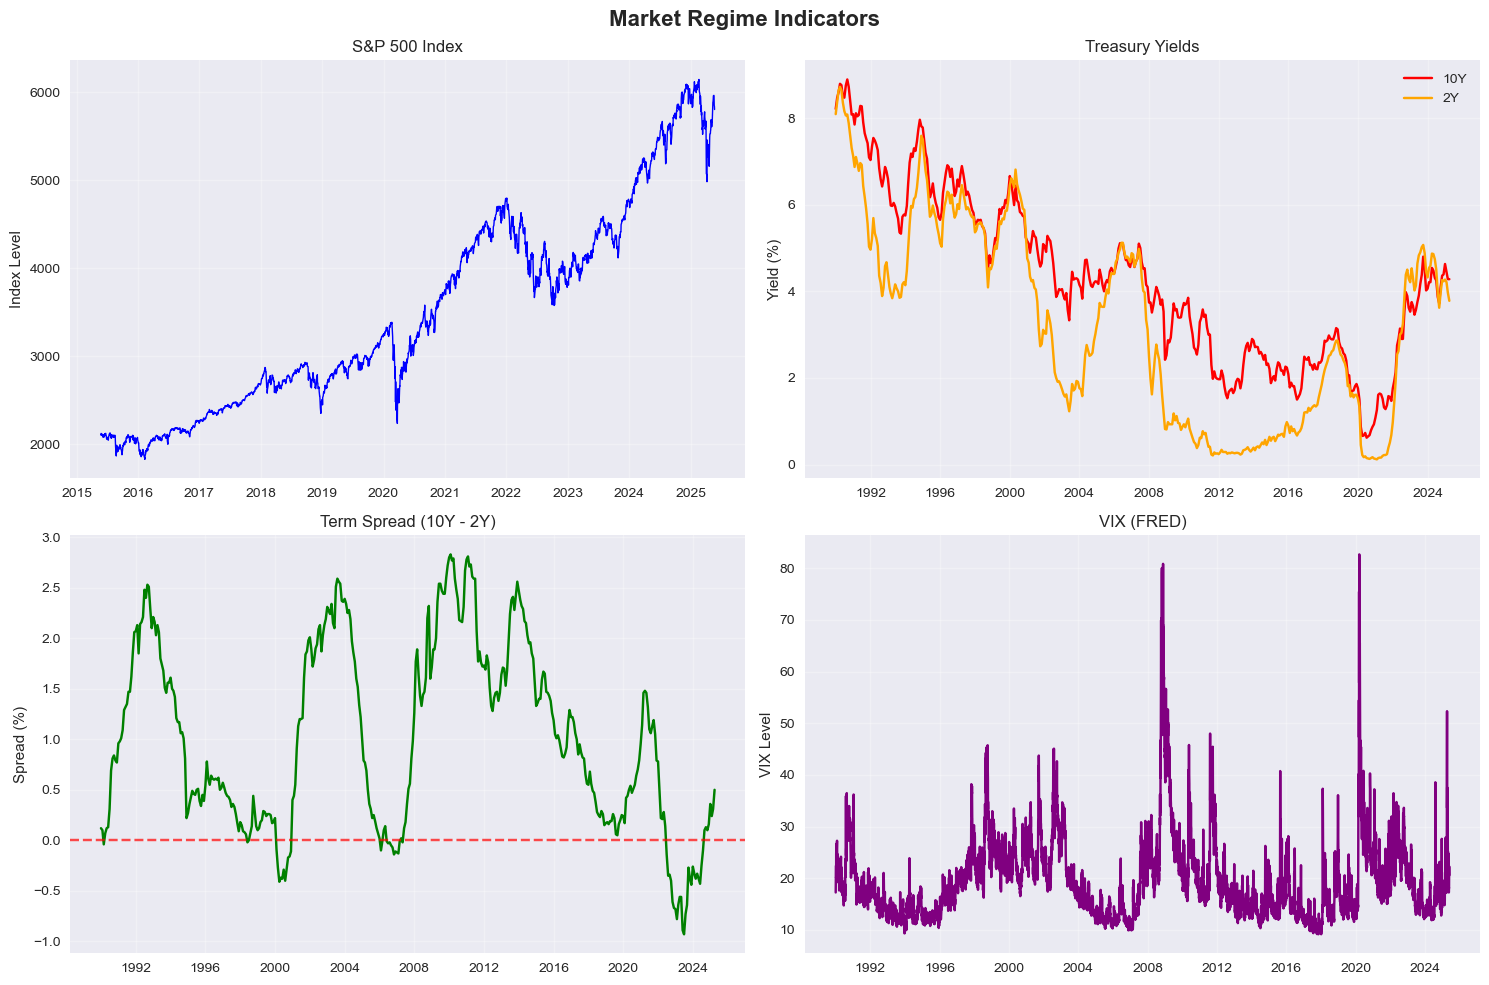

In [4]:
# =============================================================================
# CELL 2: Market Regime Indicators
# =============================================================================

print("📈 MARKET REGIME INDICATORS")
print("=" * 40)

# Create subplot grid for market regime data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Market Regime Indicators', fontsize=16, fontweight='bold')

# Load and plot S&P 500
try:
    sp500 = pd.read_csv("fred/market_regime/SP500.csv")
    sp500['date'] = pd.to_datetime(sp500['date'])
    
    axes[0,0].plot(sp500['date'], sp500['SP500'], color='blue', linewidth=1)
    axes[0,0].set_title('S&P 500 Index')
    axes[0,0].set_ylabel('Index Level')
    axes[0,0].grid(True, alpha=0.3)
    print(f"✓ S&P 500: {len(sp500)} observations")
except Exception as e:
    axes[0,0].text(0.5, 0.5, 'S&P 500\nData not available', ha='center', va='center', transform=axes[0,0].transAxes)
    print(f"✗ S&P 500 failed: {e}")

# Load and plot Treasury rates
try:
    treasury_10y = pd.read_csv("fred/market_regime/TREASURY_10Y.csv")
    treasury_2y = pd.read_csv("fred/market_regime/TREASURY_2Y.csv")
    treasury_10y['date'] = pd.to_datetime(treasury_10y['date'])
    treasury_2y['date'] = pd.to_datetime(treasury_2y['date'])
    
    axes[0,1].plot(treasury_10y['date'], treasury_10y['GS10'], label='10Y', color='red')
    axes[0,1].plot(treasury_2y['date'], treasury_2y['GS2'], label='2Y', color='orange')
    axes[0,1].set_title('Treasury Yields')
    axes[0,1].set_ylabel('Yield (%)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    print(f"✓ Treasury 10Y: {len(treasury_10y)} observations")
    print(f"✓ Treasury 2Y: {len(treasury_2y)} observations")
except Exception as e:
    axes[0,1].text(0.5, 0.5, 'Treasury Yields\nData not available', ha='center', va='center', transform=axes[0,1].transAxes)
    print(f"✗ Treasury yields failed: {e}")

# Load and plot Term Spread
try:
    term_spread = pd.read_csv("fred/credit_risk/TERM_SPREAD.csv")
    term_spread['date'] = pd.to_datetime(term_spread['date'])
    
    axes[1,0].plot(term_spread['date'], term_spread['TERM_SPREAD'], color='green')
    axes[1,0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    axes[1,0].set_title('Term Spread (10Y - 2Y)')
    axes[1,0].set_ylabel('Spread (%)')
    axes[1,0].grid(True, alpha=0.3)
    print(f"✓ Term Spread: {len(term_spread)} observations")
except Exception as e:
    axes[1,0].text(0.5, 0.5, 'Term Spread\nData not available', ha='center', va='center', transform=axes[1,0].transAxes)
    print(f"✗ Term spread failed: {e}")

# Load and plot VIX from FRED
try:
    vix_fred = pd.read_csv("fred/market_regime/VIX_FRED.csv")
    vix_fred['date'] = pd.to_datetime(vix_fred['date'])
    
    axes[1,1].plot(vix_fred['date'], vix_fred['VIXCLS'], color='purple')
    axes[1,1].set_title('VIX (FRED)')
    axes[1,1].set_ylabel('VIX Level')
    axes[1,1].grid(True, alpha=0.3)
    print(f"✓ VIX (FRED): {len(vix_fred)} observations")
except Exception as e:
    axes[1,1].text(0.5, 0.5, 'VIX\nData not available', ha='center', va='center', transform=axes[1,1].transAxes)
    print(f"✗ VIX (FRED) failed: {e}")

plt.tight_layout()
plt.show()




🏦 CREDIT RISK INDICATORS
✓ AAA Bonds: 424 observations
✓ BAA Bonds: 424 observations
✓ IG Spread: 424 observations
✓ High Yield Spread: 7413 observations
✓ TED Spread: 7869 observations


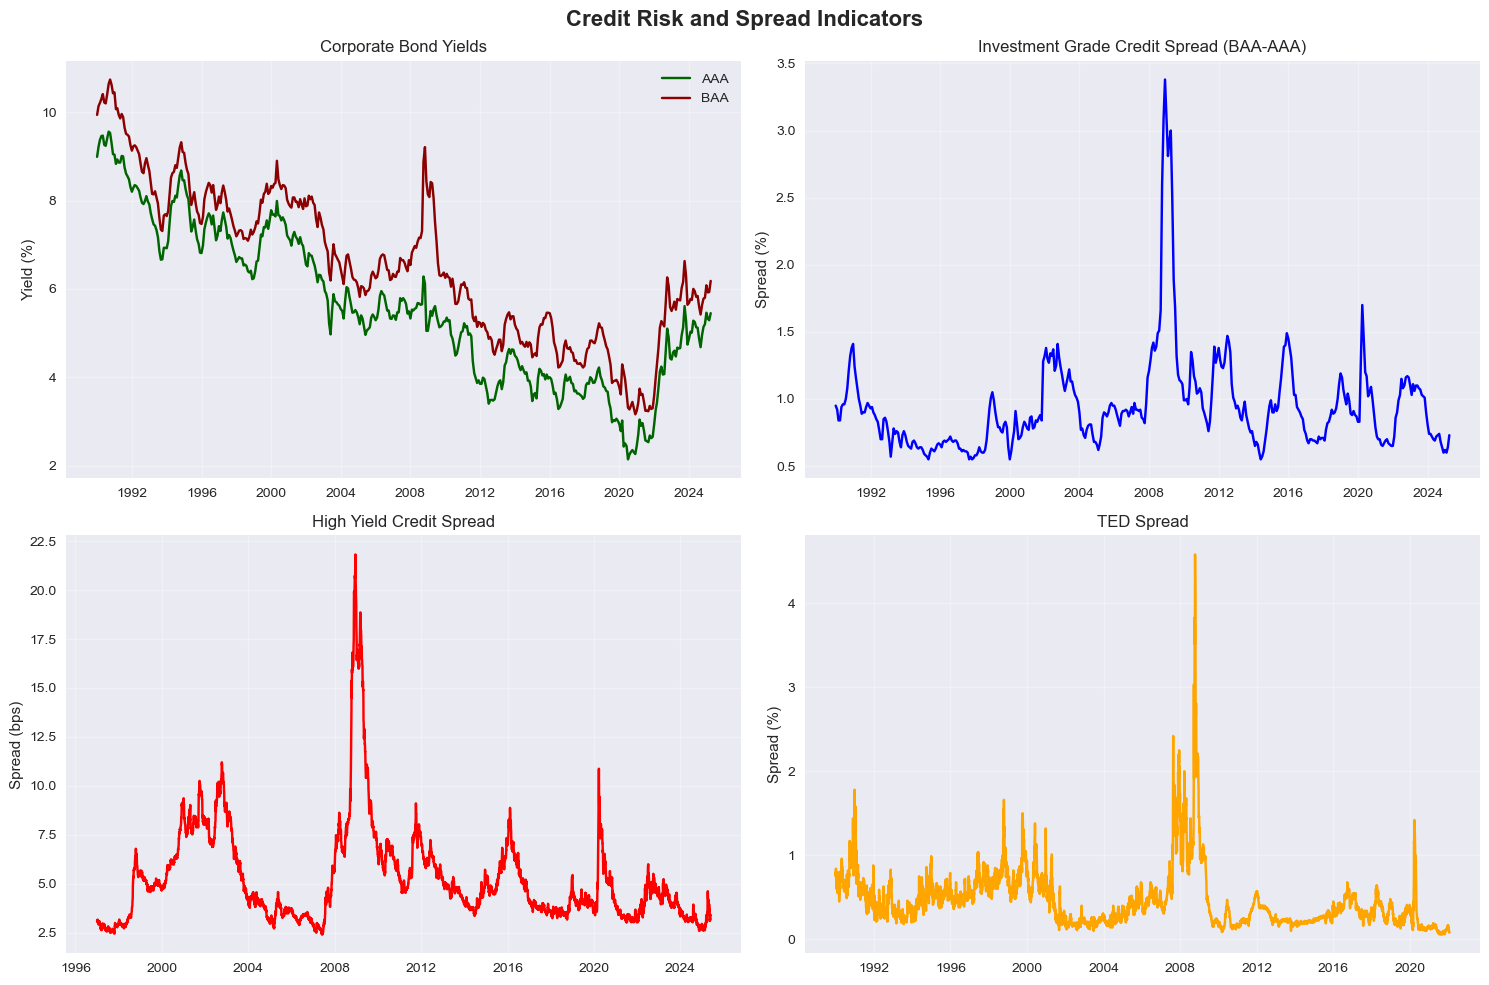

In [5]:
# =============================================================================
# CELL 3: Credit Risk Indicators
# =============================================================================

print("\n🏦 CREDIT RISK INDICATORS")
print("=" * 40)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Credit Risk and Spread Indicators', fontsize=16, fontweight='bold')

# Load and plot Corporate Bond Yields
try:
    aaa = pd.read_csv("fred/credit_risk/CREDIT_SPREAD_AAA.csv")
    baa = pd.read_csv("fred/credit_risk/CREDIT_SPREAD_BAA.csv")
    aaa['date'] = pd.to_datetime(aaa['date'])
    baa['date'] = pd.to_datetime(baa['date'])
    
    axes[0,0].plot(aaa['date'], aaa['AAA'], label='AAA', color='darkgreen')
    axes[0,0].plot(baa['date'], baa['BAA'], label='BAA', color='darkred')
    axes[0,0].set_title('Corporate Bond Yields')
    axes[0,0].set_ylabel('Yield (%)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    print(f"✓ AAA Bonds: {len(aaa)} observations")
    print(f"✓ BAA Bonds: {len(baa)} observations")
except Exception as e:
    axes[0,0].text(0.5, 0.5, 'Corporate Bonds\nData not available', ha='center', va='center', transform=axes[0,0].transAxes)
    print(f"✗ Corporate bonds failed: {e}")

# Load and plot Investment Grade Spread
try:
    ig_spread = pd.read_csv("fred/credit_risk/CREDIT_SPREAD_IG.csv")
    ig_spread['date'] = pd.to_datetime(ig_spread['date'])
    
    axes[0,1].plot(ig_spread['date'], ig_spread['CREDIT_SPREAD_IG'], color='blue')
    axes[0,1].set_title('Investment Grade Credit Spread (BAA-AAA)')
    axes[0,1].set_ylabel('Spread (%)')
    axes[0,1].grid(True, alpha=0.3)
    print(f"✓ IG Spread: {len(ig_spread)} observations")
except Exception as e:
    axes[0,1].text(0.5, 0.5, 'IG Credit Spread\nData not available', ha='center', va='center', transform=axes[0,1].transAxes)
    print(f"✗ IG spread failed: {e}")

# Load and plot High Yield Spread
try:
    hy_spread = pd.read_csv("fred/credit_risk/HIGH_YIELD_SPREAD.csv")
    hy_spread['date'] = pd.to_datetime(hy_spread['date'])
    
    axes[1,0].plot(hy_spread['date'], hy_spread['BAMLH0A0HYM2'], color='red')
    axes[1,0].set_title('High Yield Credit Spread')
    axes[1,0].set_ylabel('Spread (bps)')
    axes[1,0].grid(True, alpha=0.3)
    print(f"✓ High Yield Spread: {len(hy_spread)} observations")
except Exception as e:
    axes[1,0].text(0.5, 0.5, 'High Yield Spread\nData not available', ha='center', va='center', transform=axes[1,0].transAxes)
    print(f"✗ High yield spread failed: {e}")

# Load and plot TED Spread
try:
    ted_spread = pd.read_csv("fred/credit_risk/TED_SPREAD.csv")
    ted_spread['date'] = pd.to_datetime(ted_spread['date'])
    
    axes[1,1].plot(ted_spread['date'], ted_spread['TEDRATE'], color='orange')
    axes[1,1].set_title('TED Spread')
    axes[1,1].set_ylabel('Spread (%)')
    axes[1,1].grid(True, alpha=0.3)
    print(f"✓ TED Spread: {len(ted_spread)} observations")
except Exception as e:
    axes[1,1].text(0.5, 0.5, 'TED Spread\nData not available', ha='center', va='center', transform=axes[1,1].transAxes)
    print(f"✗ TED spread failed: {e}")

plt.tight_layout()
plt.show()




💱 CURRENCY & INTERNATIONAL INDICATORS
✓ USD Index: 4858 observations
✓ EUR/USD: 6615 observations
✓ USD/JPY: 8879 observations
✓ GBP/USD: 8879 observations
✓ EM Bond Spread: 6894 observations


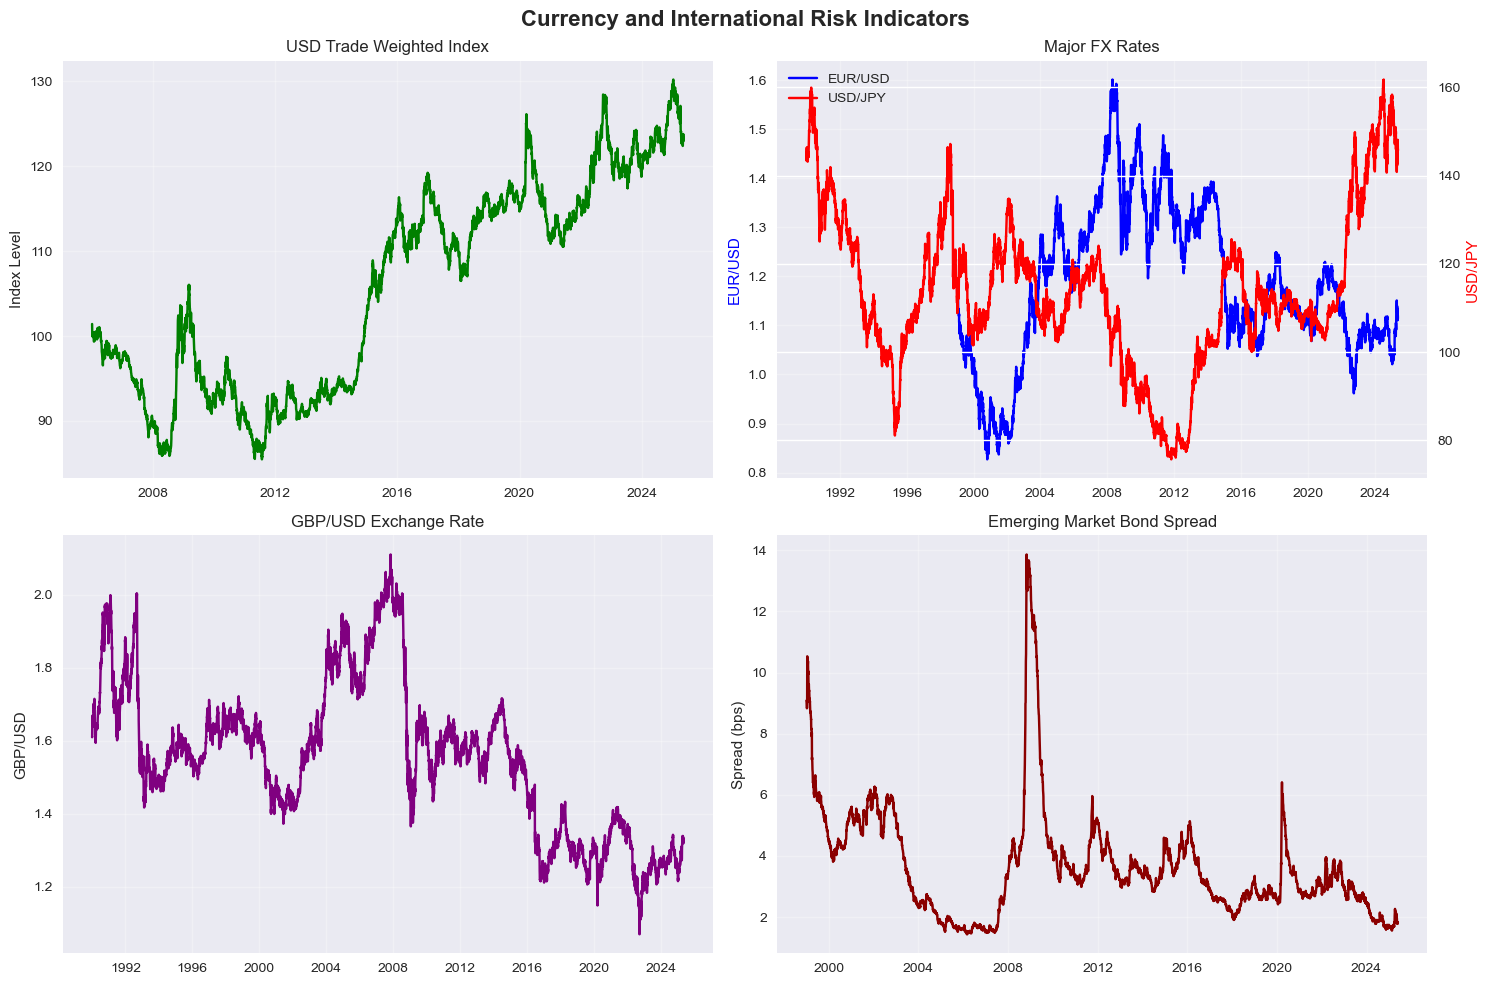

In [6]:
# =============================================================================
# CELL 4: Currency and International Indicators
# =============================================================================

print("\n💱 CURRENCY & INTERNATIONAL INDICATORS")
print("=" * 40)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Currency and International Risk Indicators', fontsize=16, fontweight='bold')

# Load and plot USD Index
try:
    usd_index = pd.read_csv("fred/currency/USD_INDEX.csv")
    usd_index['date'] = pd.to_datetime(usd_index['date'])
    
    axes[0,0].plot(usd_index['date'], usd_index['DTWEXBGS'], color='green')
    axes[0,0].set_title('USD Trade Weighted Index')
    axes[0,0].set_ylabel('Index Level')
    axes[0,0].grid(True, alpha=0.3)
    print(f"✓ USD Index: {len(usd_index)} observations")
except Exception as e:
    axes[0,0].text(0.5, 0.5, 'USD Index\nData not available', ha='center', va='center', transform=axes[0,0].transAxes)
    print(f"✗ USD Index failed: {e}")

# Load and plot Major FX Rates
try:
    eur = pd.read_csv("fred/currency/USD_EUR.csv")
    jpy = pd.read_csv("fred/currency/USD_JPY.csv")
    eur['date'] = pd.to_datetime(eur['date'])
    jpy['date'] = pd.to_datetime(jpy['date'])
    
    ax1 = axes[0,1]
    ax2 = ax1.twinx()
    
    line1 = ax1.plot(eur['date'], eur['DEXUSEU'], color='blue', label='EUR/USD')
    line2 = ax2.plot(jpy['date'], jpy['DEXJPUS'], color='red', label='USD/JPY')
    
    ax1.set_ylabel('EUR/USD', color='blue')
    ax2.set_ylabel('USD/JPY', color='red')
    ax1.set_title('Major FX Rates')
    ax1.grid(True, alpha=0.3)
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')
    
    print(f"✓ EUR/USD: {len(eur)} observations")
    print(f"✓ USD/JPY: {len(jpy)} observations")
except Exception as e:
    axes[0,1].text(0.5, 0.5, 'FX Rates\nData not available', ha='center', va='center', transform=axes[0,1].transAxes)
    print(f"✗ FX rates failed: {e}")

# Load and plot GBP
try:
    gbp = pd.read_csv("fred/currency/USD_GBP.csv")
    gbp['date'] = pd.to_datetime(gbp['date'])
    
    axes[1,0].plot(gbp['date'], gbp['DEXUSUK'], color='purple')
    axes[1,0].set_title('GBP/USD Exchange Rate')
    axes[1,0].set_ylabel('GBP/USD')
    axes[1,0].grid(True, alpha=0.3)
    print(f"✓ GBP/USD: {len(gbp)} observations")
except Exception as e:
    axes[1,0].text(0.5, 0.5, 'GBP/USD\nData not available', ha='center', va='center', transform=axes[1,0].transAxes)
    print(f"✗ GBP/USD failed: {e}")

# Load and plot Emerging Market Bond Spread
try:
    em_bonds = pd.read_csv("fred/currency/EMERGING_MARKET_BOND.csv")
    em_bonds['date'] = pd.to_datetime(em_bonds['date'])
    
    axes[1,1].plot(em_bonds['date'], em_bonds['BAMLEMCBPIOAS'], color='darkred')
    axes[1,1].set_title('Emerging Market Bond Spread')
    axes[1,1].set_ylabel('Spread (bps)')
    axes[1,1].grid(True, alpha=0.3)
    print(f"✓ EM Bond Spread: {len(em_bonds)} observations")
except Exception as e:
    axes[1,1].text(0.5, 0.5, 'EM Bond Spread\nData not available', ha='center', va='center', transform=axes[1,1].transAxes)
    print(f"✗ EM bond spread failed: {e}")

plt.tight_layout()
plt.show()




📊 ECONOMIC INDICATORS
✓ Unemployment: 424 observations
✓ Core Inflation: 424 observations
✓ Headline Inflation: 424 observations
✓ Consumer Sentiment: 423 observations
✗ ISM PMI failed: [Errno 2] No such file or directory: 'fred/economic/ISM_PMI.csv'
✓ GDP Growth: 141 observations
✓ Fed Funds Rate: 424 observations


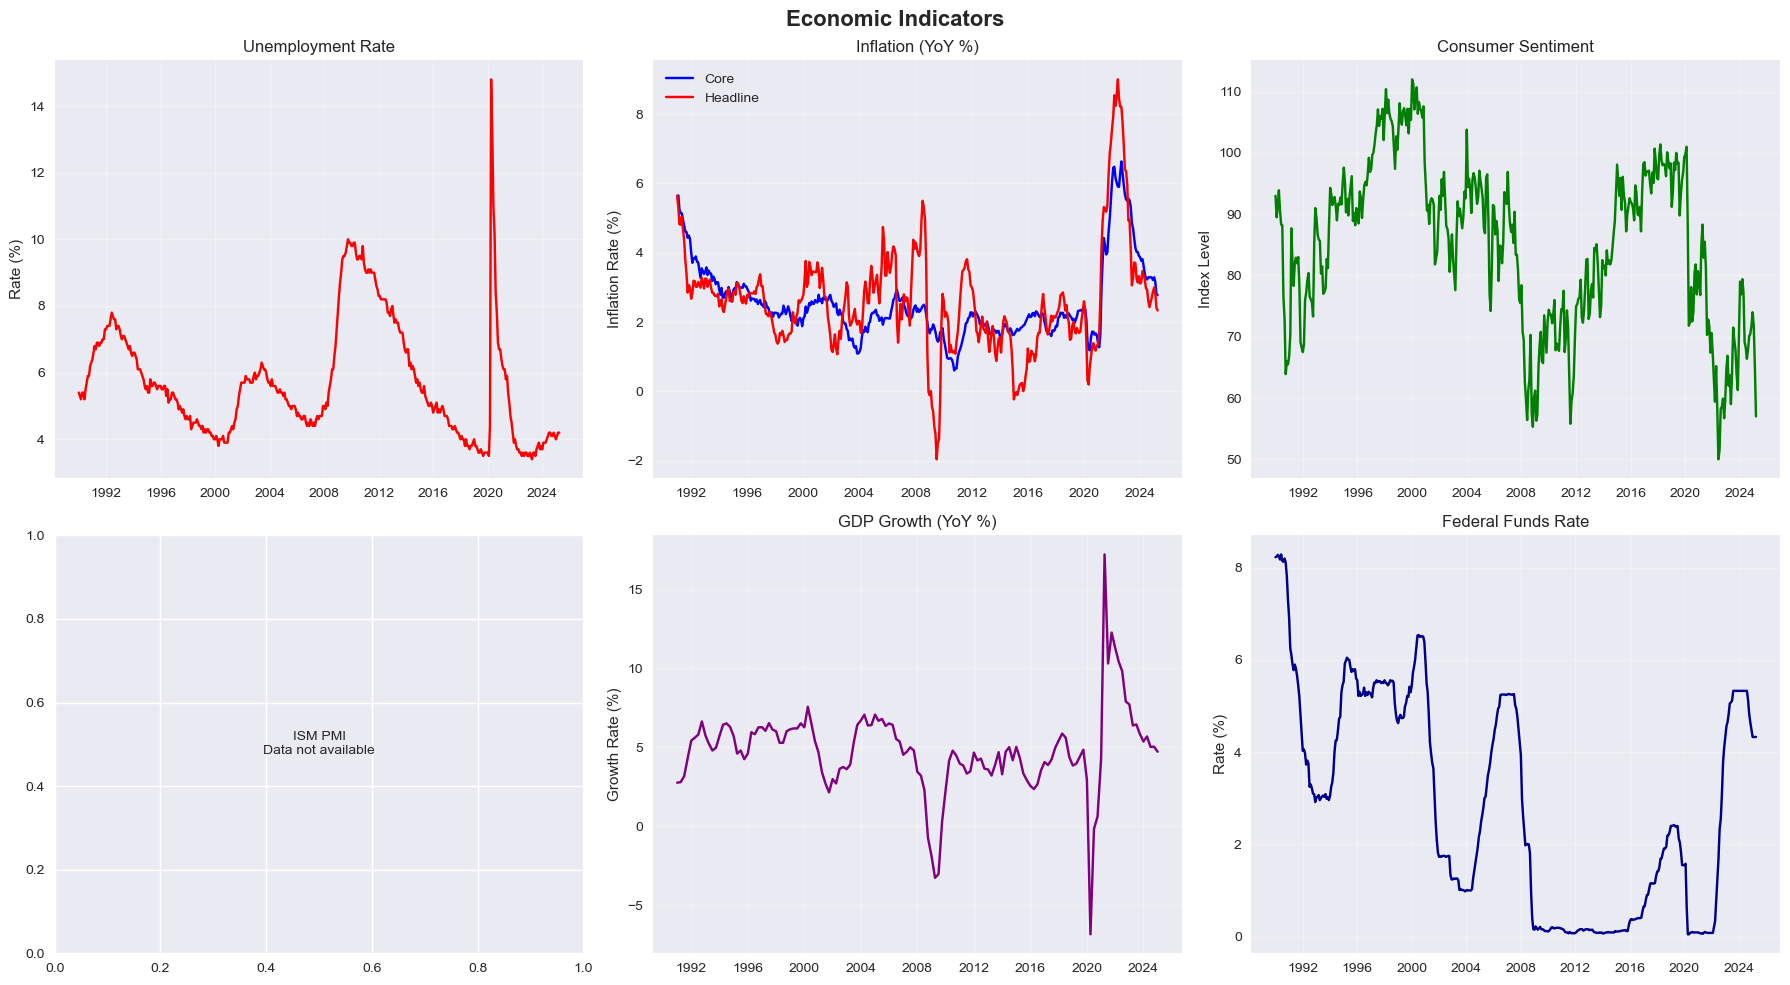

In [7]:
# =============================================================================
# CELL 5: Economic Indicators
# =============================================================================

print("\n📊 ECONOMIC INDICATORS")
print("=" * 40)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Economic Indicators', fontsize=16, fontweight='bold')

# Load and plot Unemployment
try:
    unemployment = pd.read_csv("fred/economic/UNEMPLOYMENT.csv")
    unemployment['date'] = pd.to_datetime(unemployment['date'])
    
    axes[0,0].plot(unemployment['date'], unemployment['UNRATE'], color='red')
    axes[0,0].set_title('Unemployment Rate')
    axes[0,0].set_ylabel('Rate (%)')
    axes[0,0].grid(True, alpha=0.3)
    print(f"✓ Unemployment: {len(unemployment)} observations")
except Exception as e:
    axes[0,0].text(0.5, 0.5, 'Unemployment\nData not available', ha='center', va='center', transform=axes[0,0].transAxes)
    print(f"✗ Unemployment failed: {e}")

# Load and plot Inflation
try:
    inflation_core = pd.read_csv("fred/economic/INFLATION_CORE.csv")
    inflation_headline = pd.read_csv("fred/economic/INFLATION_HEADLINE.csv")
    inflation_core['date'] = pd.to_datetime(inflation_core['date'])
    inflation_headline['date'] = pd.to_datetime(inflation_headline['date'])
    
    # Calculate YoY change for CPI
    inflation_core['CORE_YOY'] = inflation_core['CPILFESL'].pct_change(12) * 100
    inflation_headline['HEADLINE_YOY'] = inflation_headline['CPIAUCSL'].pct_change(12) * 100
    
    axes[0,1].plot(inflation_core['date'], inflation_core['CORE_YOY'], label='Core', color='blue')
    axes[0,1].plot(inflation_headline['date'], inflation_headline['HEADLINE_YOY'], label='Headline', color='red')
    axes[0,1].set_title('Inflation (YoY %)')
    axes[0,1].set_ylabel('Inflation Rate (%)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    print(f"✓ Core Inflation: {len(inflation_core)} observations")
    print(f"✓ Headline Inflation: {len(inflation_headline)} observations")
except Exception as e:
    axes[0,1].text(0.5, 0.5, 'Inflation\nData not available', ha='center', va='center', transform=axes[0,1].transAxes)
    print(f"✗ Inflation failed: {e}")

# Load and plot Consumer Sentiment
try:
    sentiment = pd.read_csv("fred/economic/CONSUMER_SENTIMENT.csv")
    sentiment['date'] = pd.to_datetime(sentiment['date'])
    
    axes[0,2].plot(sentiment['date'], sentiment['UMCSENT'], color='green')
    axes[0,2].set_title('Consumer Sentiment')
    axes[0,2].set_ylabel('Index Level')
    axes[0,2].grid(True, alpha=0.3)
    print(f"✓ Consumer Sentiment: {len(sentiment)} observations")
except Exception as e:
    axes[0,2].text(0.5, 0.5, 'Consumer Sentiment\nData not available', ha='center', va='center', transform=axes[0,2].transAxes)
    print(f"✗ Consumer sentiment failed: {e}")

# Load and plot ISM PMI
try:
    pmi = pd.read_csv("fred/economic/ISM_PMI.csv")
    pmi['date'] = pd.to_datetime(pmi['date'])
    
    axes[1,0].plot(pmi['date'], pmi['NAPM'], color='orange')
    axes[1,0].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Expansion/Contraction')
    axes[1,0].set_title('ISM Manufacturing PMI')
    axes[1,0].set_ylabel('PMI Level')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    print(f"✓ ISM PMI: {len(pmi)} observations")
except Exception as e:
    axes[1,0].text(0.5, 0.5, 'ISM PMI\nData not available', ha='center', va='center', transform=axes[1,0].transAxes)
    print(f"✗ ISM PMI failed: {e}")

# Load and plot GDP Growth
try:
    gdp = pd.read_csv("fred/economic/GDP_GROWTH.csv")
    gdp['date'] = pd.to_datetime(gdp['date'])
    gdp['GDP_YOY'] = gdp['GDP'].pct_change(4) * 100  # YoY growth for quarterly data
    
    axes[1,1].plot(gdp['date'], gdp['GDP_YOY'], color='purple')
    axes[1,1].set_title('GDP Growth (YoY %)')
    axes[1,1].set_ylabel('Growth Rate (%)')
    axes[1,1].grid(True, alpha=0.3)
    print(f"✓ GDP Growth: {len(gdp)} observations")
except Exception as e:
    axes[1,1].text(0.5, 0.5, 'GDP Growth\nData not available', ha='center', va='center', transform=axes[1,1].transAxes)
    print(f"✗ GDP growth failed: {e}")

# Load and plot Fed Funds Rate
try:
    fed_funds = pd.read_csv("fred/market_regime/FED_FUNDS.csv")
    fed_funds['date'] = pd.to_datetime(fed_funds['date'])
    
    axes[1,2].plot(fed_funds['date'], fed_funds['FEDFUNDS'], color='darkblue')
    axes[1,2].set_title('Federal Funds Rate')
    axes[1,2].set_ylabel('Rate (%)')
    axes[1,2].grid(True, alpha=0.3)
    print(f"✓ Fed Funds Rate: {len(fed_funds)} observations")
except Exception as e:
    axes[1,2].text(0.5, 0.5, 'Fed Funds Rate\nData not available', ha='center', va='center', transform=axes[1,2].transAxes)
    print(f"✗ Fed funds rate failed: {e}")

plt.tight_layout()
plt.show()




🏗️ MARKET STRUCTURE INDICATORS
✓ SOFR: 1785 observations
✗ 3M LIBOR failed: [Errno 2] No such file or directory: 'fred/market_structure/LIBOR_USD_3M.csv'
✓ Margin Debt: 140 observations


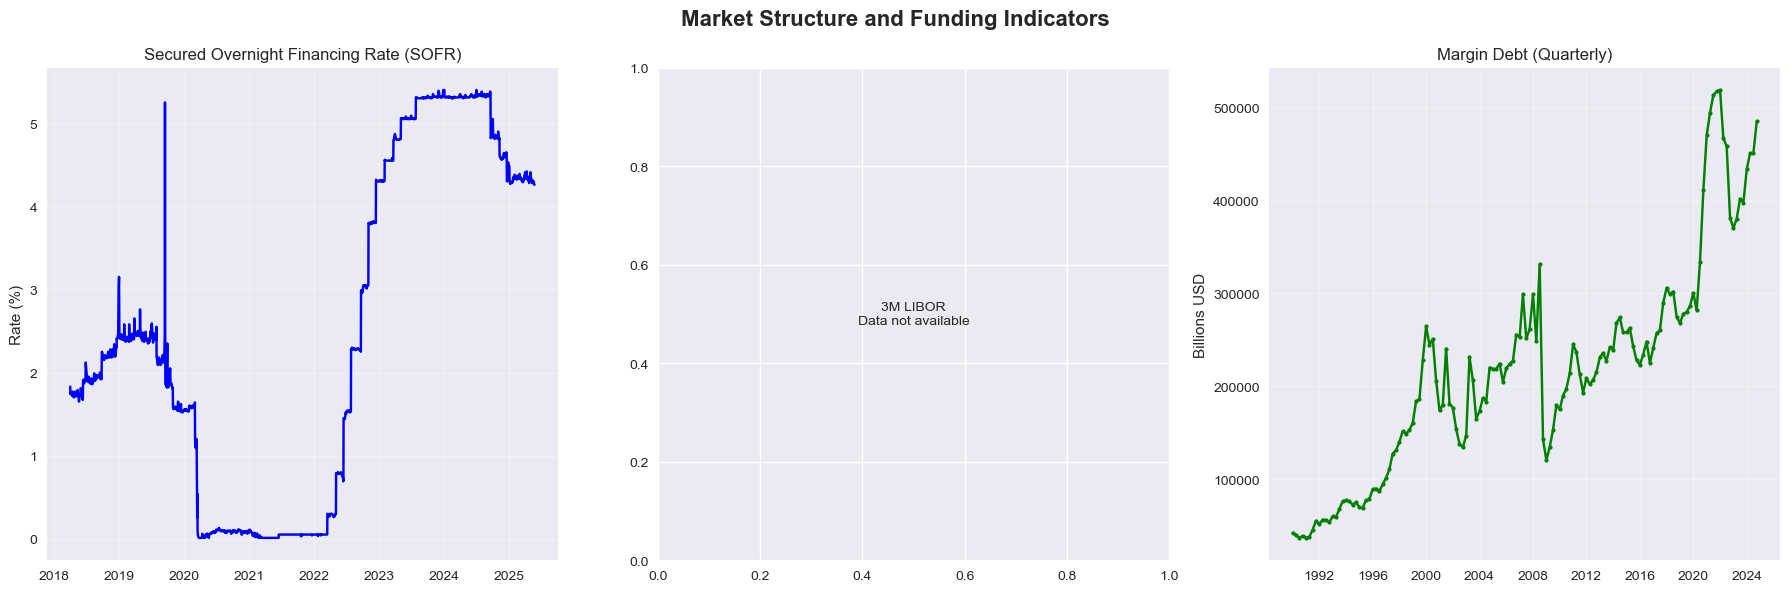

In [8]:
# =============================================================================
# CELL 6: Market Structure Indicators
# =============================================================================

print("\n🏗️ MARKET STRUCTURE INDICATORS")
print("=" * 40)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Market Structure and Funding Indicators', fontsize=16, fontweight='bold')

# Load and plot SOFR
try:
    sofr = pd.read_csv("fred/market_structure/REPO_RATE.csv")
    sofr['date'] = pd.to_datetime(sofr['date'])
    
    axes[0].plot(sofr['date'], sofr['SOFR'], color='blue')
    axes[0].set_title('Secured Overnight Financing Rate (SOFR)')
    axes[0].set_ylabel('Rate (%)')
    axes[0].grid(True, alpha=0.3)
    print(f"✓ SOFR: {len(sofr)} observations")
except Exception as e:
    axes[0].text(0.5, 0.5, 'SOFR\nData not available', ha='center', va='center', transform=axes[0].transAxes)
    print(f"✗ SOFR failed: {e}")

# Load and plot LIBOR
try:
    libor = pd.read_csv("fred/market_structure/LIBOR_USD_3M.csv")
    libor['date'] = pd.to_datetime(libor['date'])
    
    axes[1].plot(libor['date'], libor['USD3MTD156N'], color='red')
    axes[1].set_title('3-Month USD LIBOR')
    axes[1].set_ylabel('Rate (%)')
    axes[1].grid(True, alpha=0.3)
    print(f"✓ 3M LIBOR: {len(libor)} observations")
except Exception as e:
    axes[1].text(0.5, 0.5, '3M LIBOR\nData not available', ha='center', va='center', transform=axes[1].transAxes)
    print(f"✗ 3M LIBOR failed: {e}")

# Load and plot Margin Debt (quarterly data)
try:
    margin = pd.read_csv("fred/market_structure/MARGIN_DEBT.csv")
    margin['date'] = pd.to_datetime(margin['date'])
    
    axes[2].plot(margin['date'], margin['BOGZ1FL663067003Q'], color='green', marker='o', markersize=3)
    axes[2].set_title('Margin Debt (Quarterly)')
    axes[2].set_ylabel('Billions USD')
    axes[2].grid(True, alpha=0.3)
    print(f"✓ Margin Debt: {len(margin)} observations")
except Exception as e:
    axes[2].text(0.5, 0.5, 'Margin Debt\nData not available', ha='center', va='center', transform=axes[2].transAxes)
    print(f"✗ Margin debt failed: {e}")

plt.tight_layout()
plt.show()




🔗 CROSS-CORRELATION ANALYSIS
✓ Loaded VIX for correlation analysis
✓ Loaded S&P500 for correlation analysis
✓ Loaded Term_Spread for correlation analysis
✓ Loaded IG_Spread for correlation analysis
✓ Loaded HY_Spread for correlation analysis
✓ Loaded USD_Index for correlation analysis
✓ Loaded Unemployment for correlation analysis
✓ Loaded Consumer_Sentiment for correlation analysis
✓ Loaded Fed_Funds for correlation analysis


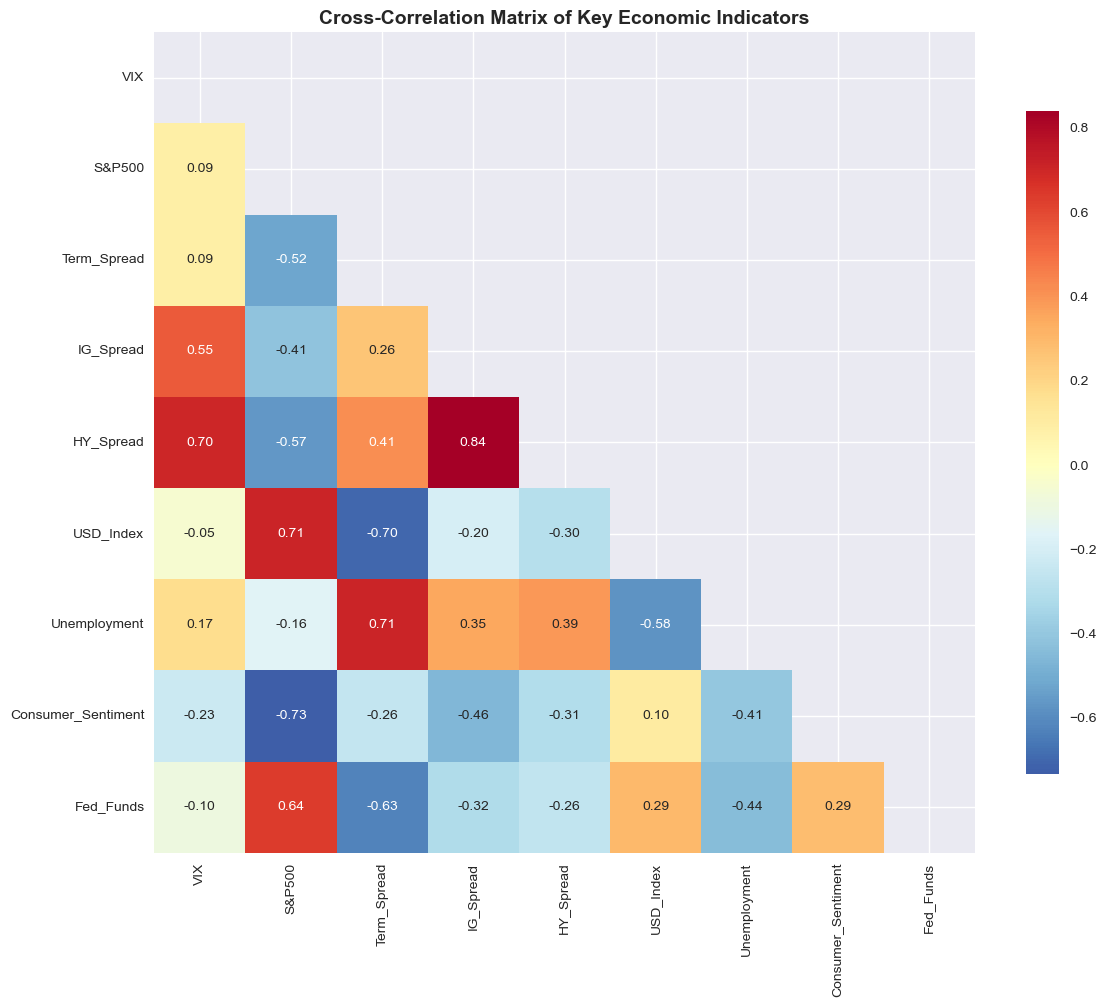


🔍 NOTABLE CORRELATIONS:
------------------------------
IG_Spread ↔ HY_Spread: 0.841
S&P500 ↔ Consumer_Sentiment: -0.734
Term_Spread ↔ Unemployment: 0.710
S&P500 ↔ USD_Index: 0.707
VIX ↔ HY_Spread: 0.700
Term_Spread ↔ USD_Index: -0.700
S&P500 ↔ Fed_Funds: 0.643
Term_Spread ↔ Fed_Funds: -0.630
USD_Index ↔ Unemployment: -0.576
S&P500 ↔ HY_Spread: -0.567

✅ FRED Data Visualization Complete!
📋 Summary: Visualized 9 key economic indicators
🎯 Next Step: Align this FRED data with your CBOE volatility indices for meta-learning


In [9]:
# =============================================================================
# CELL 7: Cross-Correlation Heatmap
# =============================================================================

print("\n🔗 CROSS-CORRELATION ANALYSIS")
print("=" * 40)

# Collect all available data for correlation analysis
correlation_data = {}

# List of key series to include in correlation
key_series = [
    ("fred/market_regime/VIX_FRED.csv", "VIXCLS", "VIX"),
    ("fred/market_regime/SP500.csv", "SP500", "S&P500"),
    ("fred/credit_risk/TERM_SPREAD.csv", "TERM_SPREAD", "Term_Spread"),
    ("fred/credit_risk/CREDIT_SPREAD_IG.csv", "CREDIT_SPREAD_IG", "IG_Spread"),
    ("fred/credit_risk/HIGH_YIELD_SPREAD.csv", "BAMLH0A0HYM2", "HY_Spread"),
    ("fred/currency/USD_INDEX.csv", "DTWEXBGS", "USD_Index"),
    ("fred/economic/UNEMPLOYMENT.csv", "UNRATE", "Unemployment"),
    ("fred/economic/CONSUMER_SENTIMENT.csv", "UMCSENT", "Consumer_Sentiment"),
    ("fred/market_regime/FED_FUNDS.csv", "FEDFUNDS", "Fed_Funds")
]

# Load data for correlation
for file_path, column, name in key_series:
    try:
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')[column]
        correlation_data[name] = df
        print(f"✓ Loaded {name} for correlation analysis")
    except Exception as e:
        print(f"✗ Failed to load {name}: {e}")

if correlation_data:
    # Combine all series into one DataFrame
    corr_df = pd.DataFrame(correlation_data)
    
    # Calculate monthly data to reduce noise
    corr_monthly = corr_df.resample('M').last()
    
    # Calculate correlation matrix
    corr_matrix = corr_monthly.corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdYlBu_r', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={"shrink": .8})
    
    plt.title('Cross-Correlation Matrix of Key Economic Indicators', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print highest correlations
    print("\n🔍 NOTABLE CORRELATIONS:")
    print("-" * 30)
    
    # Get correlation pairs (excluding diagonal)
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))
    
    # Sort by absolute correlation
    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    # Display top 10 correlations
    for var1, var2, corr in corr_pairs[:10]:
        print(f"{var1} ↔ {var2}: {corr:.3f}")

else:
    print("❌ No data available for correlation analysis")

print(f"\n✅ FRED Data Visualization Complete!")
print(f"📋 Summary: Visualized {len([x for x in key_series if Path(x[0]).exists()])} key economic indicators")
print(f"🎯 Next Step: Align this FRED data with your CBOE volatility indices for meta-learning")

## Causal Inference Data Download


In [6]:
import requests
import pandas as pd
from pathlib import Path
import time

# Create EPU folder
epu_folder = Path("epu")
epu_folder.mkdir(exist_ok=True)

def download_epu_data():
    """Download Economic Policy Uncertainty Index with robust sheet detection"""
    print("--- Downloading Economic Policy Uncertainty Data ---")
    
    # Try multiple EPU data sources
    epu_sources = [
        {
            'name': 'US Monthly EPU (Direct CSV)',
            'url': 'https://www.policyuncertainty.com/media/US_Policy_Uncertainty_Data.txt',
            'format': 'txt'
        },
        {
            'name': 'US Monthly EPU (Excel)',
            'url': 'https://www.policyuncertainty.com/media/US_Policy_Uncertainty_Data.xlsx',
            'format': 'xlsx'
        }
    ]
    
    for source in epu_sources:
        try:
            print(f"Trying {source['name']}...")
            response = requests.get(source['url'])
            response.raise_for_status()
            
            if source['format'] == 'txt':
                # Handle text/CSV format
                epu_file = epu_folder / "US_Policy_Uncertainty_Data.txt"
                with open(epu_file, 'wb') as f:
                    f.write(response.content)
                
                # Try to read as CSV (tab or comma separated)
                try:
                    epu_df = pd.read_csv(epu_file, sep='\t')
                except:
                    epu_df = pd.read_csv(epu_file, sep=',')
                
                # Save as CSV
                epu_csv = epu_folder / "policy_uncertainty_monthly.csv"
                epu_df.to_csv(epu_csv, index=False)
                print(f"  ✓ Saved EPU data to {epu_csv}")
                return
                
            elif source['format'] == 'xlsx':
                # Handle Excel format
                epu_file = epu_folder / "US_Policy_Uncertainty_Data.xlsx"
                with open(epu_file, 'wb') as f:
                    f.write(response.content)
                
                # Check what sheets are available
                excel_file = pd.ExcelFile(epu_file)
                print(f"  Available sheets: {excel_file.sheet_names}")
                
                # Try different sheet names
                possible_sheets = [
                    'Monthly_Policy_Uncertainty',
                    'Data',
                    'Sheet1',
                    'US_Policy_Uncertainty_Data',
                    excel_file.sheet_names[0]  # First sheet
                ]
                
                for sheet_name in possible_sheets:
                    try:
                        if sheet_name in excel_file.sheet_names:
                            epu_df = pd.read_excel(epu_file, sheet_name=sheet_name)
                            
                            # Save as CSV
                            epu_csv = epu_folder / "policy_uncertainty_monthly.csv"
                            epu_df.to_csv(epu_csv, index=False)
                            print(f"  ✓ Saved EPU data from sheet '{sheet_name}' to {epu_csv}")
                            return
                    except Exception as e:
                        continue
                        
        except Exception as e:
            print(f"  ✗ Failed {source['name']}: {e}")
            continue
    
    # If all else fails, create a manual EPU proxy using FRED VIX data
    print("  → Creating EPU proxy from VIX data...")
    create_epu_proxy()

def create_epu_proxy():
    """Create a simple EPU proxy using VIX and other volatility measures"""
    try:
        # Read VIX data from your FRED download
        vix_file = Path("fred/market_regime/VIX_FRED.csv")
        if vix_file.exists():
            vix_df = pd.read_csv(vix_file)
            vix_df['date'] = pd.to_datetime(vix_df['date'])
            
            # Create simple policy uncertainty proxy
            # High VIX periods often coincide with policy uncertainty
            vix_df['policy_uncertainty_proxy'] = vix_df['VIXCLS'].rolling(30).std() * vix_df['VIXCLS']
            
            # Normalize to make it look like EPU index
            vix_df['policy_uncertainty_proxy'] = (
                (vix_df['policy_uncertainty_proxy'] - vix_df['policy_uncertainty_proxy'].mean()) / 
                vix_df['policy_uncertainty_proxy'].std() * 50 + 100
            )
            
            # Save proxy
            proxy_file = epu_folder / "policy_uncertainty_proxy.csv"
            epu_proxy = vix_df[['date', 'policy_uncertainty_proxy']].dropna()
            epu_proxy.to_csv(proxy_file, index=False)
            
            print(f"  ✓ Created EPU proxy from VIX data: {proxy_file}")
            print(f"    Note: This is a proxy based on VIX volatility patterns")
            
        else:
            print("  ✗ Cannot create EPU proxy - VIX data not found")
            
    except Exception as e:
        print(f"  ✗ Failed to create EPU proxy: {e}")

# Run EPU download with error handling
download_epu_data()

--- Downloading Economic Policy Uncertainty Data ---
Trying US Monthly EPU (Direct CSV)...
  ✗ Failed US Monthly EPU (Direct CSV): 404 Client Error: Not Found for url: https://www.policyuncertainty.com/media/US_Policy_Uncertainty_Data.txt
Trying US Monthly EPU (Excel)...
  Available sheets: ['Main News Index', 'Legacy Three Component EPU']
  ✓ Saved EPU data from sheet 'Main News Index' to epu/policy_uncertainty_monthly.csv


In [2]:
import re
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

# Create Fed events folder
fed_events_folder = Path("fed_events")
fed_events_folder.mkdir(exist_ok=True)

def download_fomc_calendar():
    """Download FOMC meeting dates and create event timeline"""
    print("\n--- Downloading Federal Reserve Event Data ---")
    
    # FOMC meeting calendar (we'll create a simplified version)
    # In practice, you'd scrape https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm
    
    # For now, let's create a manual timeline of major Fed events
    major_fed_events = [
        # Financial Crisis Era
        {'date': '2008-09-16', 'event': 'Emergency rate cut', 'type': 'rate_cut', 'magnitude': -0.5},
        {'date': '2008-10-08', 'event': 'Coordinated rate cut', 'type': 'rate_cut', 'magnitude': -0.5},
        {'date': '2008-10-29', 'event': 'Rate cut to 1%', 'type': 'rate_cut', 'magnitude': -0.5},
        {'date': '2008-12-16', 'event': 'Rate cut to zero', 'type': 'rate_cut', 'magnitude': -0.75},
        
        # QE Era
        {'date': '2008-11-25', 'event': 'QE1 announcement', 'type': 'qe_announcement', 'magnitude': 1},
        {'date': '2010-11-03', 'event': 'QE2 announcement', 'type': 'qe_announcement', 'magnitude': 1},
        {'date': '2012-09-13', 'event': 'QE3 announcement', 'type': 'qe_announcement', 'magnitude': 1},
        
        # Taper and Normalization
        {'date': '2013-05-22', 'event': 'Taper tantrum (Bernanke speech)', 'type': 'taper_hint', 'magnitude': -1},
        {'date': '2013-12-18', 'event': 'Taper announcement', 'type': 'taper_announcement', 'magnitude': -1},
        {'date': '2014-10-29', 'event': 'QE3 ends', 'type': 'qe_end', 'magnitude': -1},
        
        # Rate Hike Cycle
        {'date': '2015-12-16', 'event': 'First rate hike post-crisis', 'type': 'rate_hike', 'magnitude': 0.25},
        {'date': '2016-12-14', 'event': 'Second rate hike', 'type': 'rate_hike', 'magnitude': 0.25},
        {'date': '2017-03-15', 'event': 'Third rate hike', 'type': 'rate_hike', 'magnitude': 0.25},
        {'date': '2017-06-14', 'event': 'Fourth rate hike', 'type': 'rate_hike', 'magnitude': 0.25},
        {'date': '2017-12-13', 'event': 'Fifth rate hike', 'type': 'rate_hike', 'magnitude': 0.25},
        
        # 2018-2019 Cycle
        {'date': '2018-03-21', 'event': 'Powell first hike', 'type': 'rate_hike', 'magnitude': 0.25},
        {'date': '2018-06-13', 'event': 'June rate hike', 'type': 'rate_hike', 'magnitude': 0.25},
        {'date': '2018-09-26', 'event': 'September rate hike', 'type': 'rate_hike', 'magnitude': 0.25},
        {'date': '2018-12-19', 'event': 'December rate hike', 'type': 'rate_hike', 'magnitude': 0.25},
        {'date': '2019-07-31', 'event': 'First rate cut since crisis', 'type': 'rate_cut', 'magnitude': -0.25},
        {'date': '2019-09-18', 'event': 'September rate cut', 'type': 'rate_cut', 'magnitude': -0.25},
        {'date': '2019-10-30', 'event': 'October rate cut', 'type': 'rate_cut', 'magnitude': -0.25},
        
        # COVID Era
        {'date': '2020-03-03', 'event': 'Emergency rate cut', 'type': 'rate_cut', 'magnitude': -0.5},
        {'date': '2020-03-15', 'event': 'Emergency rate cut to zero', 'type': 'rate_cut', 'magnitude': -1.0},
        {'date': '2020-03-23', 'event': 'Unlimited QE announcement', 'type': 'qe_announcement', 'magnitude': 2},
        
        # Current Era
        {'date': '2022-03-16', 'event': 'First post-COVID rate hike', 'type': 'rate_hike', 'magnitude': 0.25},
        {'date': '2022-05-04', 'event': 'May rate hike', 'type': 'rate_hike', 'magnitude': 0.5},
        {'date': '2022-06-15', 'event': 'June rate hike', 'type': 'rate_hike', 'magnitude': 0.75},
        {'date': '2022-07-27', 'event': 'July rate hike', 'type': 'rate_hike', 'magnitude': 0.75},
        {'date': '2022-09-21', 'event': 'September rate hike', 'type': 'rate_hike', 'magnitude': 0.75},
        {'date': '2022-11-02', 'event': 'November rate hike', 'type': 'rate_hike', 'magnitude': 0.75},
        {'date': '2022-12-14', 'event': 'December rate hike', 'type': 'rate_hike', 'magnitude': 0.5},
        {'date': '2023-02-01', 'event': 'February rate hike', 'type': 'rate_hike', 'magnitude': 0.25},
        {'date': '2023-03-22', 'event': 'March rate hike', 'type': 'rate_hike', 'magnitude': 0.25},
        {'date': '2023-05-03', 'event': 'May rate hike', 'type': 'rate_hike', 'magnitude': 0.25},
        {'date': '2023-07-26', 'event': 'July rate hike', 'type': 'rate_hike', 'magnitude': 0.25},
    ]
    
    # Convert to DataFrame
    fed_events_df = pd.DataFrame(major_fed_events)
    fed_events_df['date'] = pd.to_datetime(fed_events_df['date'])
    
    # Save to CSV
    fed_events_file = fed_events_folder / "fomc_major_events.csv"
    fed_events_df.to_csv(fed_events_file, index=False)
    print(f"  ✓ Saved {len(fed_events_df)} major Fed events to {fed_events_file}")
    
    return fed_events_df

# Run Fed events download
fed_events = download_fomc_calendar()


--- Downloading Federal Reserve Event Data ---
  ✓ Saved 36 major Fed events to fed_events/fomc_major_events.csv


In [3]:
# Create market events folder
market_events_folder = Path("market_events")
market_events_folder.mkdir(exist_ok=True)

def create_market_event_timeline():
    """Create timeline of major market events for instrumental variables"""
    print("\n--- Creating Market Event Timeline ---")
    
    major_market_events = [
        # Financial Crisis
        {'date': '2008-09-15', 'event': 'Lehman Brothers collapse', 'type': 'financial_crisis', 'sector': 'banking'},
        {'date': '2008-09-16', 'event': 'AIG bailout', 'type': 'bailout', 'sector': 'insurance'},
        {'date': '2008-10-03', 'event': 'TARP signed', 'type': 'policy_response', 'sector': 'banking'},
        
        # European Crisis
        {'date': '2010-05-02', 'event': 'Greece bailout', 'type': 'sovereign_crisis', 'sector': 'sovereign'},
        {'date': '2011-08-05', 'event': 'US credit downgrade', 'type': 'rating_change', 'sector': 'sovereign'},
        {'date': '2012-07-26', 'event': 'Draghi "whatever it takes"', 'type': 'central_bank_speech', 'sector': 'currency'},
        
        # Flash Crash and Market Structure
        {'date': '2010-05-06', 'event': 'Flash crash', 'type': 'market_structure', 'sector': 'equity'},
        {'date': '2015-08-24', 'event': 'China devaluation crash', 'type': 'currency_crisis', 'sector': 'emerging_markets'},
        
        # Political Events
        {'date': '2016-06-23', 'event': 'Brexit referendum', 'type': 'political_shock', 'sector': 'currency'},
        {'date': '2016-11-08', 'event': 'Trump election', 'type': 'election', 'sector': 'political'},
        {'date': '2020-11-07', 'event': 'Biden election called', 'type': 'election', 'sector': 'political'},
        
        # Trade Wars
        {'date': '2018-03-22', 'event': 'First China tariffs', 'type': 'trade_war', 'sector': 'international'},
        {'date': '2019-05-05', 'event': 'Tariff escalation tweet', 'type': 'trade_war', 'sector': 'international'},
        {'date': '2020-01-15', 'event': 'Phase 1 trade deal', 'type': 'trade_resolution', 'sector': 'international'},
        
        # COVID Timeline
        {'date': '2020-01-30', 'event': 'WHO declares emergency', 'type': 'pandemic', 'sector': 'health'},
        {'date': '2020-03-11', 'event': 'WHO declares pandemic', 'type': 'pandemic', 'sector': 'health'},
        {'date': '2020-03-16', 'event': 'US lockdowns begin', 'type': 'lockdown', 'sector': 'health'},
        {'date': '2020-11-09', 'event': 'Pfizer vaccine news', 'type': 'medical_breakthrough', 'sector': 'health'},
        
        # Recent Events
        {'date': '2021-01-06', 'event': 'Capitol riots', 'type': 'political_shock', 'sector': 'political'},
        {'date': '2022-02-24', 'event': 'Russia invades Ukraine', 'type': 'geopolitical_shock', 'sector': 'geopolitical'},
        {'date': '2023-03-10', 'event': 'Silicon Valley Bank collapse', 'type': 'banking_crisis', 'sector': 'banking'},
    ]
    
    # Convert to DataFrame
    market_events_df = pd.DataFrame(major_market_events)
    market_events_df['date'] = pd.to_datetime(market_events_df['date'])
    
    # Save to CSV
    market_events_file = market_events_folder / "major_market_events.csv"
    market_events_df.to_csv(market_events_file, index=False)
    print(f"  ✓ Saved {len(market_events_df)} major market events to {market_events_file}")
    
    return market_events_df

# Run market events creation
market_events = create_market_event_timeline()


--- Creating Market Event Timeline ---
  ✓ Saved 21 major market events to market_events/major_market_events.csv


In [4]:
# Create CBOE events folder
cboe_events_folder = Path("cboe_events")
cboe_events_folder.mkdir(exist_ok=True)

def create_vix_methodology_timeline():
    """Create timeline of VIX calculation changes (natural experiments)"""
    print("\n--- Creating VIX Methodology Timeline ---")
    
    vix_changes = [
        {'date': '1993-01-01', 'event': 'VIX launch (original methodology)', 'type': 'methodology_change', 'impact': 'new_product'},
        {'date': '2003-09-22', 'event': 'New VIX methodology (model-free)', 'type': 'methodology_change', 'impact': 'calculation_change'},
        {'date': '2004-03-26', 'event': 'VIX futures launch', 'type': 'product_launch', 'impact': 'derivatives_trading'},
        {'date': '2009-01-30', 'event': 'VIX options launch', 'type': 'product_launch', 'impact': 'derivatives_trading'},
        {'date': '2009-10-19', 'event': 'VVIX launch', 'type': 'product_launch', 'impact': 'vol_of_vol'},
        {'date': '2012-05-07', 'event': 'VIX9D launch', 'type': 'product_launch', 'impact': 'short_term_vol'},
        {'date': '2014-02-05', 'event': 'XIV/VXX rebalancing rules change', 'type': 'etf_rule_change', 'impact': 'trading_structure'},
        {'date': '2018-02-05', 'event': 'XIV termination event', 'type': 'product_termination', 'impact': 'vol_explosion'},
    ]
    
    # Convert to DataFrame
    vix_changes_df = pd.DataFrame(vix_changes)
    vix_changes_df['date'] = pd.to_datetime(vix_changes_df['date'])
    
    # Save to CSV
    vix_changes_file = cboe_events_folder / "vix_methodology_changes.csv"
    vix_changes_df.to_csv(vix_changes_file, index=False)
    print(f"  ✓ Saved {len(vix_changes_df)} VIX methodology events to {vix_changes_file}")
    
    return vix_changes_df

# Run VIX methodology timeline creation
vix_events = create_vix_methodology_timeline()


--- Creating VIX Methodology Timeline ---
  ✓ Saved 8 VIX methodology events to cboe_events/vix_methodology_changes.csv


In [7]:
def create_causal_data_summary():
    """Create comprehensive summary of all causal inference data"""
    print("\n--- Creating Causal Data Summary ---")
    
    # Create summary of all available data
    data_sources = {
        'fred': 'Economic and financial indicators (confounders)',
        'epu': 'Economic Policy Uncertainty (treatment intensity)',
        'fed_events': 'Federal Reserve policy events (treatments)',
        'market_events': 'Major market events (instrumental variables)',
        'cboe_events': 'VIX methodology changes (natural experiments)',
        'cboe_data': 'Your original volatility data (outcomes)'
    }
    
    causal_readiness = {
        'outcome_variables': '✓ CBOE volatility indices',
        'treatment_variables': '✓ Fed policy events, market structure changes',
        'confounding_variables': '✓ Economic indicators, market conditions',
        'instrumental_variables': '✓ Methodology changes, exogenous shocks',
        'time_series_structure': '✓ Daily frequency alignment possible',
        'causal_identification': '✓ Policy events as quasi-experiments'
    }
    
    print("\n📊 CAUSAL INFERENCE DATA SUMMARY")
    print("=" * 50)
    print("\n🗂️  Data Sources:")
    for source, description in data_sources.items():
        print(f"  • {source:15} : {description}")
    
    print("\n🎯 Causal Framework Readiness:")
    for component, status in causal_readiness.items():
        print(f"  • {component:25} : {status}")
    
    print(f"\n🚀 READY FOR CAUSAL INFERENCE!")
    print("You now have all the data needed to implement:")
    print("  1. Double Machine Learning (DML)")
    print("  2. Event studies on Fed policy")
    print("  3. Natural experiments with VIX changes")
    print("  4. Instrumental variable analysis")
    
    # Save summary to file
    summary_file = Path("causal_data_summary.txt")
    with open(summary_file, 'w') as f:
        f.write("CAUSAL INFERENCE DATA SUMMARY\n")
        f.write("=" * 40 + "\n\n")
        f.write("Data Sources:\n")
        for source, description in data_sources.items():
            f.write(f"  • {source}: {description}\n")
        f.write(f"\nCausal Framework Components:\n")
        for component, status in causal_readiness.items():
            f.write(f"  • {component}: {status}\n")
    
    print(f"\n📝 Summary saved to: {summary_file}")

# Run final summary
create_causal_data_summary()


--- Creating Causal Data Summary ---

📊 CAUSAL INFERENCE DATA SUMMARY

🗂️  Data Sources:
  • fred            : Economic and financial indicators (confounders)
  • epu             : Economic Policy Uncertainty (treatment intensity)
  • fed_events      : Federal Reserve policy events (treatments)
  • market_events   : Major market events (instrumental variables)
  • cboe_events     : VIX methodology changes (natural experiments)
  • cboe_data       : Your original volatility data (outcomes)

🎯 Causal Framework Readiness:
  • outcome_variables         : ✓ CBOE volatility indices
  • treatment_variables       : ✓ Fed policy events, market structure changes
  • confounding_variables     : ✓ Economic indicators, market conditions
  • instrumental_variables    : ✓ Methodology changes, exogenous shocks
  • time_series_structure     : ✓ Daily frequency alignment possible
  • causal_identification     : ✓ Policy events as quasi-experiments

🚀 READY FOR CAUSAL INFERENCE!
You now have all the dat

## CBOE VIX Data Visualization

🎯 VOLATILITY PREDICTION TARGETS ANALYSIS
Loading CBOE data files...
  ✓ Loaded VIX: 8924 observations from 1990-01-02 00:00:00 to 2025-05-09 00:00:00
  ✓ Loaded VIX9D: 3609 observations from 2011-01-04 00:00:00 to 2025-05-09 00:00:00
  ✓ Loaded VIX3M: 3951 observations from 2009-09-18 00:00:00 to 2025-06-03 00:00:00
  ✓ Loaded VVIX: 4766 observations from 2006-03-06 00:00:00 to 2025-05-09 00:00:00
  ✓ Loaded OVX: 3933 observations from 2009-09-18 00:00:00 to 2025-05-09 00:00:00
  ✓ Loaded GVZ: 3933 observations from 2009-09-18 00:00:00 to 2025-05-09 00:00:00
  ✓ Loaded VXAPL: 3602 observations from 2011-01-07 00:00:00 to 2025-05-09 00:00:00
  ✓ Loaded VXEEM: 3556 observations from 2011-03-16 00:00:00 to 2025-05-09 00:00:00
  ✗ File not found: VAZN_History.csv

Creating target variables...
  ✓ Term Structure Slope: 3609 observations
  ✓ Vol Risk Premium: 8923 observations
  ✓ Cross-Asset Correlation: 3931 observations
  ✓ Volatility Dispersion: 3556 observations using ['VXAPL', 'VXEEM']

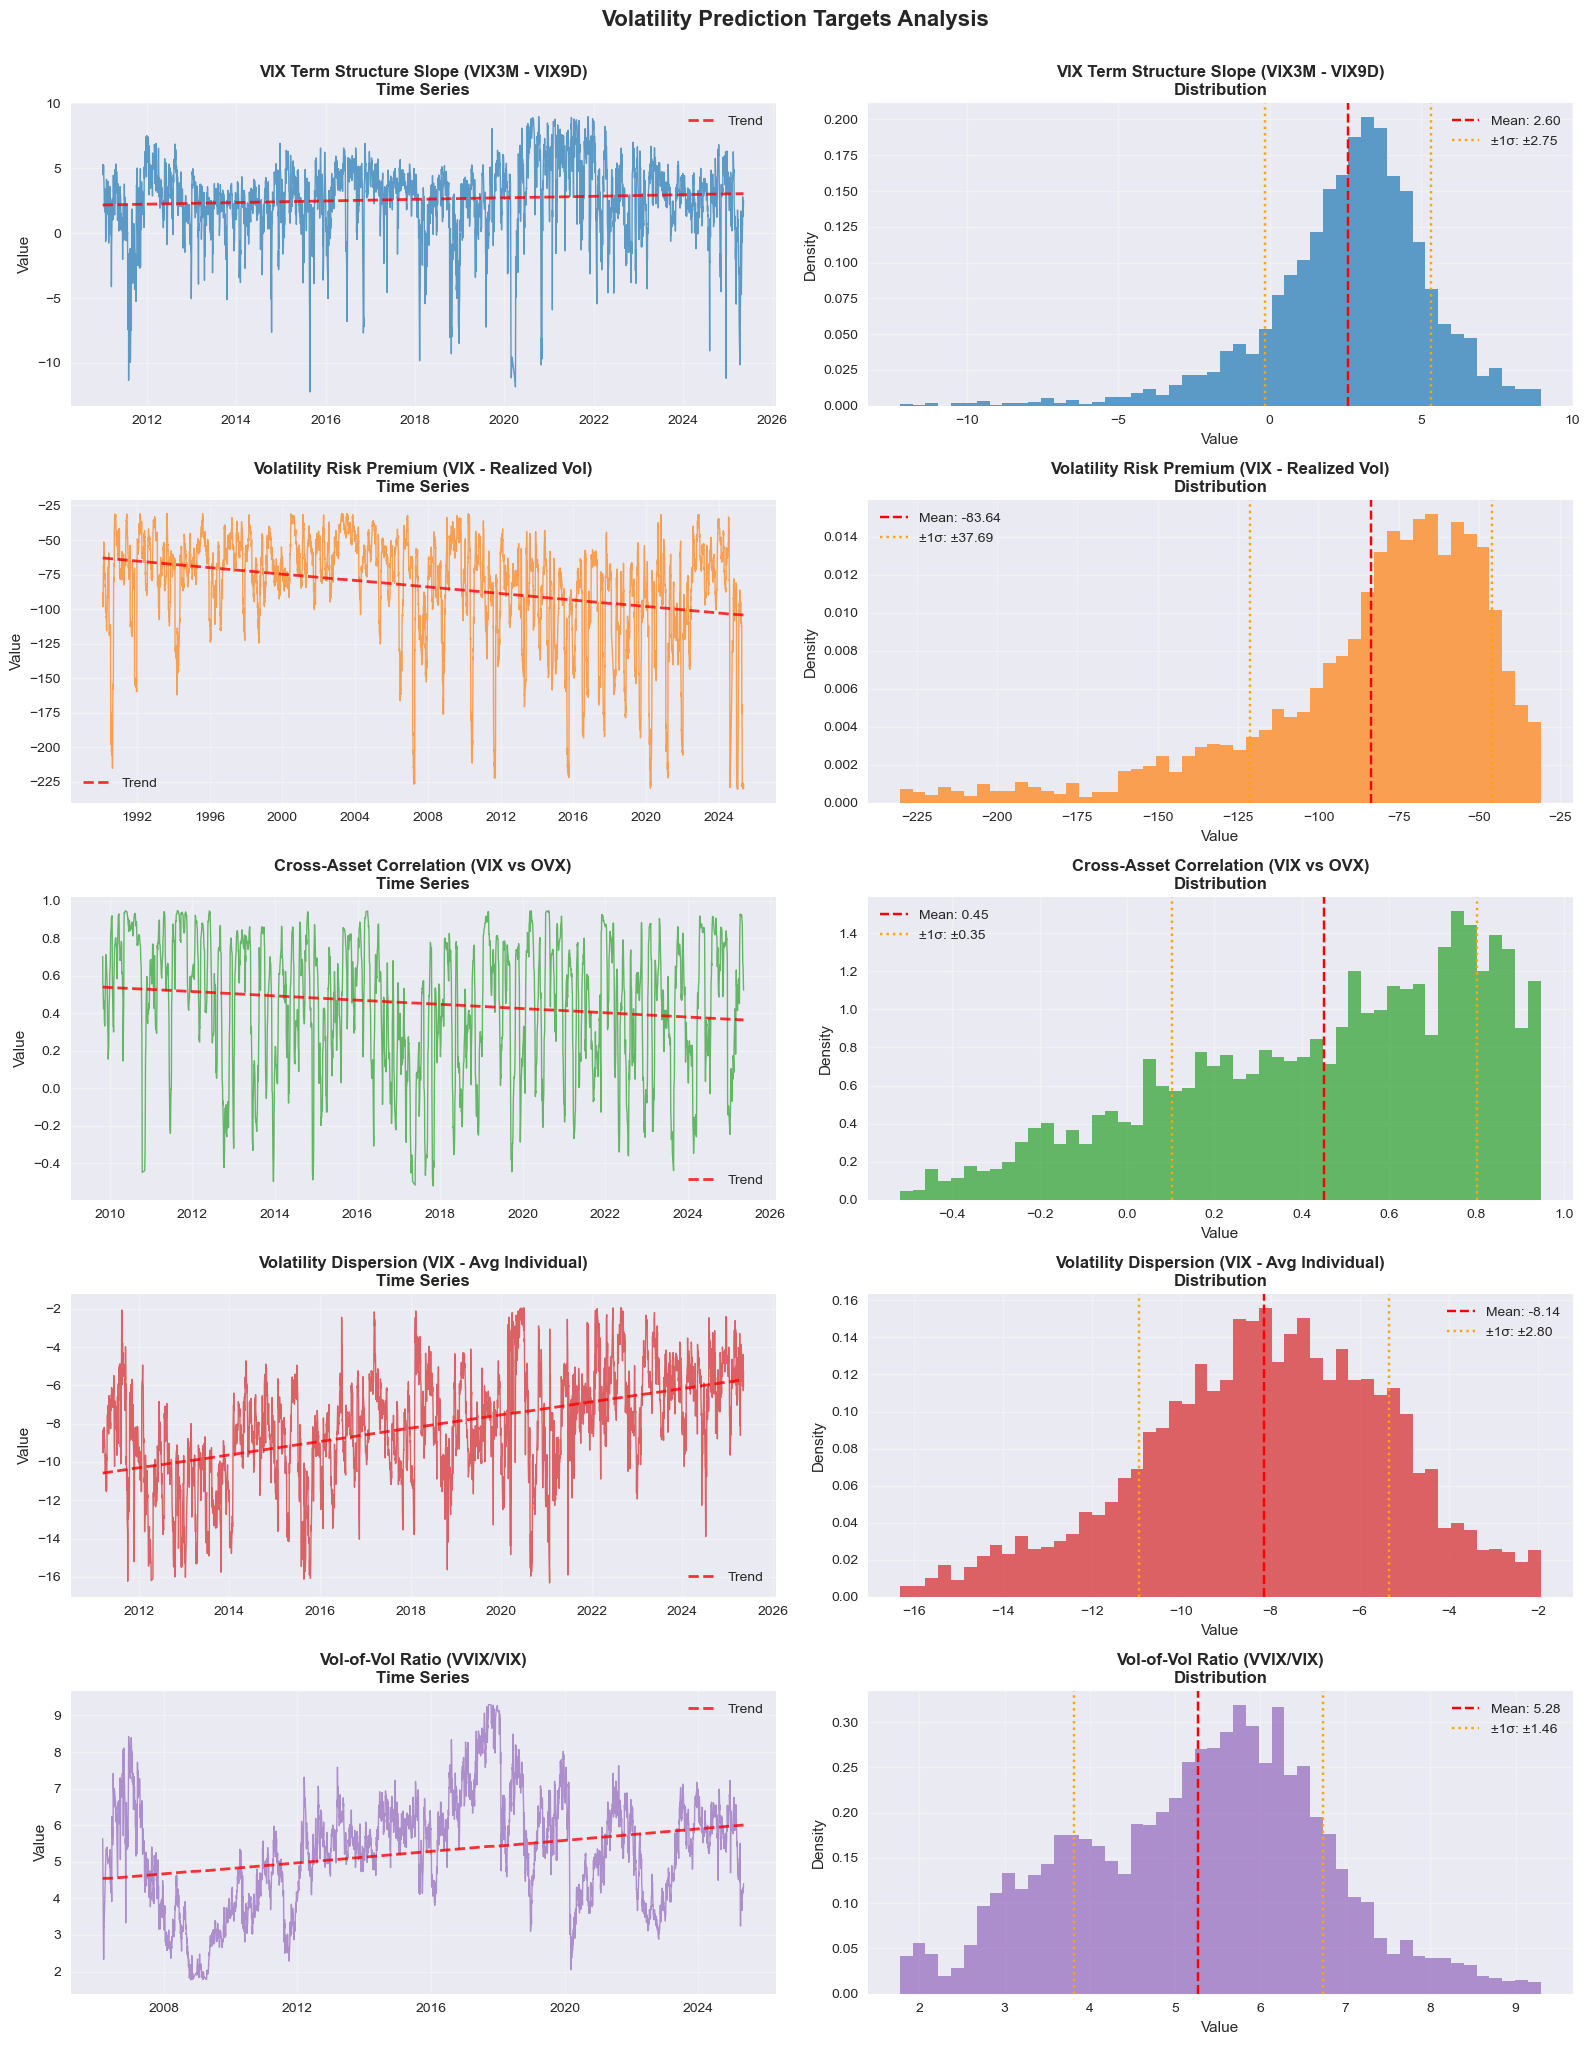


VOLATILITY PREDICTION TARGETS SUMMARY

📊 Term Structure Slope
   • Observations: 3,609
   • Period: 2011-01-04 to 2025-05-09
   • Mean ± Std: 2.424 ± 3.799
   • Range: [-46.320, 12.490]
   • Skewness: -3.650
   • Trend Slope: 0.000217

📊 Vol Risk Premium
   • Observations: 8,894
   • Period: 1990-02-13 to 2025-05-09
   • Mean ± Std: -85.040 ± 42.908
   • Range: [-376.075, -14.417]
   • Skewness: -2.041
   • Trend Slope: -0.005644

📊 Cross Asset Correlation
   • Observations: 3,902
   • Period: 2009-10-29 to 2025-05-09
   • Mean ± Std: 0.446 ± 0.366
   • Range: [-0.757, 0.971]
   • Skewness: -0.710
   • Trend Slope: -0.000042

📊 Volatility Dispersion
   • Observations: 3,556
   • Period: 2011-03-16 to 2025-05-09
   • Mean ± Std: -8.160 ± 3.044
   • Range: [-25.595, 6.610]
   • Skewness: -0.373
   • Trend Slope: 0.001490

📊 Vol Of Vol Ratio
   • Observations: 4,766
   • Period: 2006-03-06 to 2025-05-09
   • Mean ± Std: 5.283 ± 1.559
   • Range: [1.319, 10.317]
   • Skewness: 0.003
   • 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class VolatilityTargetAnalyzer:
    def __init__(self, data_path="cboe_data/"):
        self.data_path = Path(data_path)
        self.data = {}
        
    def load_cboe_data(self):
        """Load all available CBOE data files"""
        print("Loading CBOE data files...")
        
        # Define file mappings
        file_mappings = {
            'VIX': 'VIX_History.csv',
            'VIX9D': 'VIX9D_History.csv', 
            'VIX3M': 'VIX3M_History.csv',
            'VVIX': 'VVIX_History.csv',
            'OVX': 'OVX_History.csv',
            'GVZ': 'GVZ_History.csv',
            'VXAPL': 'VXAPL_History.csv',
            'VXEEM': 'VXEEM_History.csv',
            'VAZN': 'VAZN_History.csv'
        }
        
        for name, filename in file_mappings.items():
            filepath = self.data_path / filename
            if filepath.exists():
                try:
                    df = pd.read_csv(filepath)
                    df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
                    df = df.set_index('DATE').sort_index()
                    
                    # Handle different data formats
                    if name in ['VVIX', 'OVX', 'GVZ']:
                        # Single value format
                        if name == 'VVIX':
                            df = df.rename(columns={'VVIX': 'CLOSE'})
                        elif name == 'OVX':
                            df = df.rename(columns={'OVX': 'CLOSE'})
                        elif name == 'GVZ':
                            df = df.rename(columns={'GVZ': 'CLOSE'})
                    
                    # Store closing prices
                    self.data[name] = df['CLOSE']
                    print(f"  ✓ Loaded {name}: {len(df)} observations from {df.index.min()} to {df.index.max()}")
                    
                except Exception as e:
                    print(f"  ✗ Error loading {name}: {e}")
            else:
                print(f"  ✗ File not found: {filename}")
        
        return self.data
    
    def create_target_variables(self):
        """Create the 5 target variables for prediction"""
        print("\nCreating target variables...")
        targets = {}
        
        # 1. VIX Term Structure Slope (VIX3M - VIX9D)
        if 'VIX3M' in self.data and 'VIX9D' in self.data:
            # Align dates
            common_dates = self.data['VIX3M'].index.intersection(self.data['VIX9D'].index)
            if len(common_dates) > 0:
                targets['term_structure_slope'] = (
                    self.data['VIX3M'].loc[common_dates] - self.data['VIX9D'].loc[common_dates]
                )
                print(f"  ✓ Term Structure Slope: {len(targets['term_structure_slope'])} observations")
            else:
                print("  ✗ No overlapping dates for VIX3M and VIX9D")
        else:
            print("  ✗ Missing VIX3M or VIX9D for term structure slope")
        
        # 2. Realized vs Implied Volatility Spread (VIX - Realized Vol)
        # We'll approximate realized vol using VIX daily changes
        if 'VIX' in self.data:
            vix_series = self.data['VIX'].dropna()
            # Calculate 30-day realized volatility (annualized)
            vix_returns = vix_series.pct_change().dropna()
            realized_vol = vix_returns.rolling(30).std() * np.sqrt(252) * 100  # Annualized %
            
            # Align with VIX levels
            common_dates = vix_series.index.intersection(realized_vol.index)
            if len(common_dates) > 0:
                targets['vol_risk_premium'] = (
                    vix_series.loc[common_dates] - realized_vol.loc[common_dates]
                )
                print(f"  ✓ Vol Risk Premium: {len(targets['vol_risk_premium'])} observations")
            else:
                print("  ✗ Cannot create vol risk premium")
        else:
            print("  ✗ Missing VIX for vol risk premium")
        
        # 3. Cross-Asset Volatility Correlation (VIX vs OVX rolling correlation)
        if 'VIX' in self.data and 'OVX' in self.data:
            common_dates = self.data['VIX'].index.intersection(self.data['OVX'].index)
            if len(common_dates) > 60:  # Need enough data for correlation
                vix_aligned = self.data['VIX'].loc[common_dates]
                ovx_aligned = self.data['OVX'].loc[common_dates]
                
                targets['cross_asset_correlation'] = vix_aligned.rolling(30).corr(ovx_aligned)
                print(f"  ✓ Cross-Asset Correlation: {len(targets['cross_asset_correlation'])} observations")
            else:
                print("  ✗ Insufficient overlapping data for VIX-OVX correlation")
        else:
            print("  ✗ Missing VIX or OVX for cross-asset correlation")
        
        # 4. Volatility Dispersion (VIX - Average Individual Vol)
        individual_vols = ['VXAPL', 'VXEEM', 'VAZN']
        available_individual = [vol for vol in individual_vols if vol in self.data]
        
        if 'VIX' in self.data and len(available_individual) >= 2:
            # Find common dates across all available individual vols and VIX
            common_dates = self.data['VIX'].index
            for vol_name in available_individual:
                common_dates = common_dates.intersection(self.data[vol_name].index)
            
            if len(common_dates) > 0:
                # Calculate average individual volatility
                individual_vol_data = pd.DataFrame({
                    vol: self.data[vol].loc[common_dates] for vol in available_individual
                })
                avg_individual_vol = individual_vol_data.mean(axis=1)
                
                targets['volatility_dispersion'] = (
                    self.data['VIX'].loc[common_dates] - avg_individual_vol
                )
                print(f"  ✓ Volatility Dispersion: {len(targets['volatility_dispersion'])} observations using {available_individual}")
            else:
                print("  ✗ No common dates for volatility dispersion")
        else:
            print(f"  ✗ Missing VIX or insufficient individual vols (have: {available_individual})")
        
        # 5. Vol-of-Vol Ratio (VVIX/VIX)
        if 'VVIX' in self.data and 'VIX' in self.data:
            common_dates = self.data['VVIX'].index.intersection(self.data['VIX'].index)
            if len(common_dates) > 0:
                targets['vol_of_vol_ratio'] = (
                    self.data['VVIX'].loc[common_dates] / self.data['VIX'].loc[common_dates]
                )
                print(f"  ✓ Vol-of-Vol Ratio: {len(targets['vol_of_vol_ratio'])} observations")
            else:
                print("  ✗ No overlapping dates for VVIX and VIX")
        else:
            print("  ✗ Missing VVIX or VIX for vol-of-vol ratio")
        
        return targets
    
    def plot_target_analysis(self, targets):
        """Create comprehensive visualization of all target variables"""
        available_targets = {k: v for k, v in targets.items() if v is not None and len(v) > 0}
        n_targets = len(available_targets)
        
        if n_targets == 0:
            print("No targets available for plotting!")
            return
        
        # Create figure with subplots
        fig, axes = plt.subplots(n_targets, 2, figsize=(16, 4*n_targets))
        if n_targets == 1:
            axes = axes.reshape(1, -1)
        
        target_descriptions = {
            'term_structure_slope': 'VIX Term Structure Slope (VIX3M - VIX9D)',
            'vol_risk_premium': 'Volatility Risk Premium (VIX - Realized Vol)',
            'cross_asset_correlation': 'Cross-Asset Correlation (VIX vs OVX)',
            'volatility_dispersion': 'Volatility Dispersion (VIX - Avg Individual)',
            'vol_of_vol_ratio': 'Vol-of-Vol Ratio (VVIX/VIX)'
        }
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        
        for i, (target_name, target_data) in enumerate(available_targets.items()):
            color = colors[i % len(colors)]
            
            # Remove outliers for better visualization
            target_clean = target_data.dropna()
            q1, q99 = target_clean.quantile([0.01, 0.99])
            target_clean = target_clean[(target_clean >= q1) & (target_clean <= q99)]
            
            # Time series plot
            axes[i, 0].plot(target_clean.index, target_clean.values, 
                           color=color, alpha=0.7, linewidth=1)
            axes[i, 0].set_title(f'{target_descriptions[target_name]}\nTime Series', 
                                fontsize=12, fontweight='bold')
            axes[i, 0].set_ylabel('Value')
            axes[i, 0].grid(True, alpha=0.3)
            
            # Add trend line
            if len(target_clean) > 100:
                z = np.polyfit(range(len(target_clean)), target_clean.values, 1)
                p = np.poly1d(z)
                axes[i, 0].plot(target_clean.index, p(range(len(target_clean))), 
                               "r--", alpha=0.8, linewidth=2, label=f'Trend')
                axes[i, 0].legend()
            
            # Distribution plot
            axes[i, 1].hist(target_clean.values, bins=50, color=color, alpha=0.7, density=True)
            axes[i, 1].set_title(f'{target_descriptions[target_name]}\nDistribution', 
                                fontsize=12, fontweight='bold')
            axes[i, 1].set_xlabel('Value')
            axes[i, 1].set_ylabel('Density')
            axes[i, 1].grid(True, alpha=0.3)
            
            # Add statistics
            mean_val = target_clean.mean()
            std_val = target_clean.std()
            axes[i, 1].axvline(mean_val, color='red', linestyle='--', 
                              label=f'Mean: {mean_val:.2f}')
            axes[i, 1].axvline(mean_val + std_val, color='orange', linestyle=':', 
                              label=f'±1σ: ±{std_val:.2f}')
            axes[i, 1].axvline(mean_val - std_val, color='orange', linestyle=':')
            axes[i, 1].legend()
        
        plt.tight_layout()
        plt.suptitle('Volatility Prediction Targets Analysis', 
                     fontsize=16, fontweight='bold', y=1.02)
        plt.show()
        
        return fig
    
    def create_summary_statistics(self, targets):
        """Create summary statistics table"""
        print("\n" + "="*80)
        print("VOLATILITY PREDICTION TARGETS SUMMARY")
        print("="*80)
        
        summary_data = []
        
        for target_name, target_data in targets.items():
            if target_data is not None and len(target_data) > 0:
                target_clean = target_data.dropna()
                
                if len(target_clean) > 0:
                    # Calculate statistics
                    stats = {
                        'Target': target_name.replace('_', ' ').title(),
                        'Observations': len(target_clean),
                        'Start Date': target_clean.index.min().strftime('%Y-%m-%d'),
                        'End Date': target_clean.index.max().strftime('%Y-%m-%d'),
                        'Mean': target_clean.mean(),
                        'Std Dev': target_clean.std(),
                        'Min': target_clean.min(),
                        'Max': target_clean.max(),
                        'Skewness': target_clean.skew(),
                        'Trend Slope': np.polyfit(range(len(target_clean)), target_clean.values, 1)[0] if len(target_clean) > 1 else 0
                    }
                    summary_data.append(stats)
        
        if summary_data:
            summary_df = pd.DataFrame(summary_data)
            
            # Display formatted table
            for _, row in summary_df.iterrows():
                print(f"\n📊 {row['Target']}")
                print(f"   • Observations: {row['Observations']:,}")
                print(f"   • Period: {row['Start Date']} to {row['End Date']}")
                print(f"   • Mean ± Std: {row['Mean']:.3f} ± {row['Std Dev']:.3f}")
                print(f"   • Range: [{row['Min']:.3f}, {row['Max']:.3f}]")
                print(f"   • Skewness: {row['Skewness']:.3f}")
                print(f"   • Trend Slope: {row['Trend Slope']:.6f}")
        
        return summary_data
    
    def analyze_prediction_viability(self, targets):
        """Analyze which targets are most suitable for prediction"""
        print("\n" + "="*80)
        print("PREDICTION VIABILITY ANALYSIS")
        print("="*80)
        
        viability_scores = {}
        
        for target_name, target_data in targets.items():
            if target_data is None or len(target_data) == 0:
                continue
                
            target_clean = target_data.dropna()
            if len(target_clean) < 100:  # Need minimum data
                continue
            
            # Calculate viability metrics
            score = 0
            reasons = []
            
            # 1. Data availability (30% weight)
            data_score = min(len(target_clean) / 1000, 1.0) * 30
            score += data_score
            reasons.append(f"Data: {len(target_clean):,} obs ({data_score:.1f}/30)")
            
            # 2. Trend strength (25% weight)
            if len(target_clean) > 100:
                trend_slope = abs(np.polyfit(range(len(target_clean)), target_clean.values, 1)[0])
                trend_score = min(trend_slope * 1000, 1.0) * 25  # Scale trend
                score += trend_score
                reasons.append(f"Trend: {trend_slope:.6f} ({trend_score:.1f}/25)")
            
            # 3. Stationarity check (20% weight)
            # Simple stationarity proxy: coefficient of variation
            cv = target_clean.std() / abs(target_clean.mean()) if target_clean.mean() != 0 else float('inf')
            stationarity_score = min(2.0 / (cv + 0.1), 1.0) * 20
            score += stationarity_score
            reasons.append(f"Stability: CV={cv:.2f} ({stationarity_score:.1f}/20)")
            
            # 4. Regime structure (15% weight)
            # Check for clear regime changes using rolling statistics
            rolling_mean = target_clean.rolling(60).mean()
            regime_changes = abs(rolling_mean.diff()).sum()
            regime_score = min(regime_changes / len(target_clean) * 100, 1.0) * 15
            score += regime_score
            reasons.append(f"Regimes: {regime_changes/len(target_clean)*100:.3f} ({regime_score:.1f}/15)")
            
            # 5. Predictability proxy (10% weight)
            # Autocorrelation at lag 1
            autocorr = target_clean.autocorr() if len(target_clean) > 1 else 0
            predict_score = abs(autocorr) * 10
            score += predict_score
            reasons.append(f"Autocorr: {autocorr:.3f} ({predict_score:.1f}/10)")
            
            viability_scores[target_name] = {
                'total_score': score,
                'reasons': reasons,
                'recommendation': 'High' if score > 70 else 'Medium' if score > 50 else 'Low'
            }
        
        # Sort by score
        sorted_targets = sorted(viability_scores.items(), key=lambda x: x[1]['total_score'], reverse=True)
        
        print("\n🏆 PREDICTION TARGET RANKINGS:")
        for i, (target_name, metrics) in enumerate(sorted_targets, 1):
            recommendation = metrics['recommendation']
            emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "📊"
            
            print(f"\n{emoji} #{i}: {target_name.replace('_', ' ').title()}")
            print(f"   📈 Viability Score: {metrics['total_score']:.1f}/100 ({recommendation})")
            for reason in metrics['reasons']:
                print(f"      • {reason}")
        
        return viability_scores

# Run the complete analysis
def main():
    print("🎯 VOLATILITY PREDICTION TARGETS ANALYSIS")
    print("="*60)
    
    # Initialize analyzer
    analyzer = VolatilityTargetAnalyzer()
    
    # Load data
    data = analyzer.load_cboe_data()
    
    if not data:
        print("❌ No data loaded! Check your file paths.")
        return
    
    # Create targets
    # Create targets
    targets = analyzer.create_target_variables()

    # Fix: Check if targets contain valid data (not None and not empty)
    valid_targets = [t for t in targets.values() if t is not None and len(t) > 0]
    if not valid_targets:
        print("❌ No valid targets created!")
        return
    
    # Create visualizations
    analyzer.plot_target_analysis(targets)
    
    # Generate summary statistics
    summary = analyzer.create_summary_statistics(targets)
    
    # Analyze prediction viability
    viability = analyzer.analyze_prediction_viability(targets)
    
    print(f"\n🎉 Analysis complete! Found {len([t for t in targets.values() if t is not None])} viable prediction targets.")

# Run the analysis
main()